# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import sys
import pickle
import tensorflow as tf
from sklearn.utils import shuffle
import tsc_utils as tu
import time
import datetime

In [2]:
# Load pickled data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
norm_done = False

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

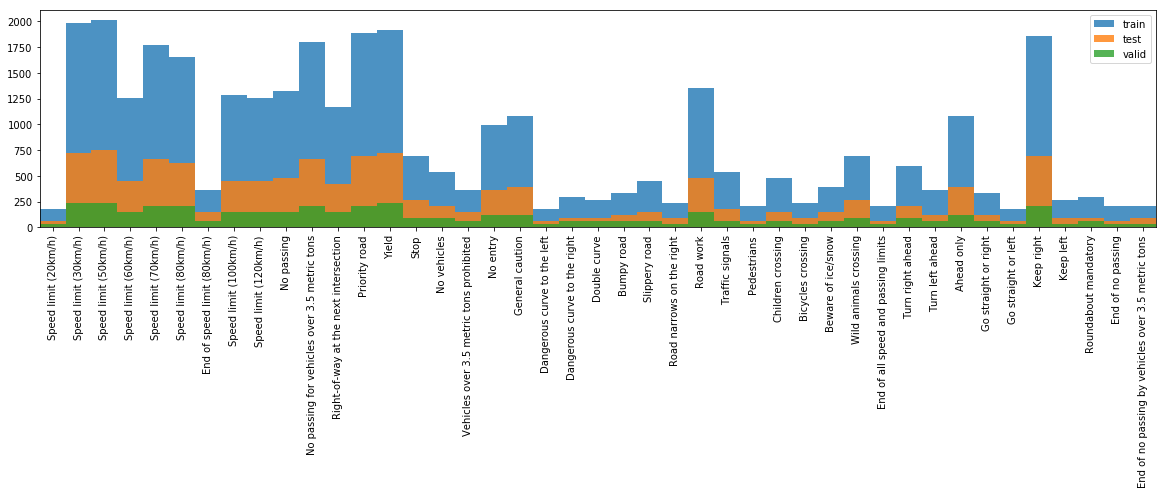

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
sign_df = pd.read_csv('signnames.csv')
df = pd.Series(y_train).value_counts().to_frame('label_counts')
sign_df = pd.merge(sign_df, df, left_on='ClassId', right_index=True)
sign_df['label_freq'] = sign_df['label_counts'] / sign_df['label_counts'].sum() 
sign_df['label_freq_normed'] = sign_df['label_freq'] / sign_df['label_freq'].mean()
sign_df = sign_df.set_index('ClassId')

def plot_data():
    plt.figure(figsize=(20,4))
    a = 0.8
    plt.hist(y_train, alpha=a, bins=np.arange(n_classes+1)-0.5)
    plt.hist(y_test, alpha=a, bins=np.arange(n_classes+1)-0.5)
    plt.hist(y_valid, alpha=a, bins=np.arange(n_classes+1)-0.5)
    plt.xticks(range(n_classes), sign_df['SignName'], rotation='vertical')
    plt.legend(['train', 'test', 'valid'])
    plt.autoscale(enable=True, axis='x', tight=True)

plot_data()

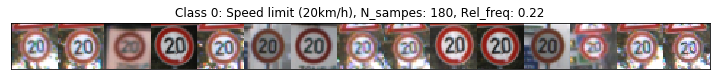

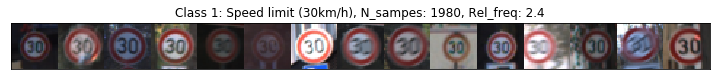

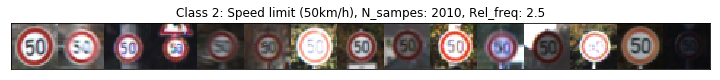

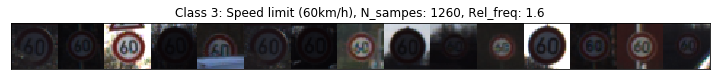

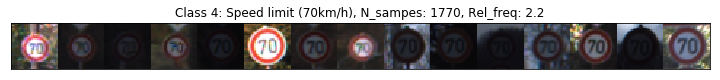

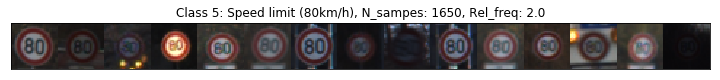

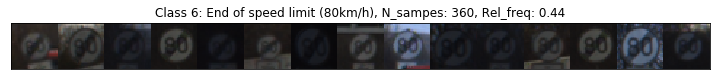

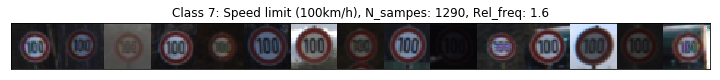

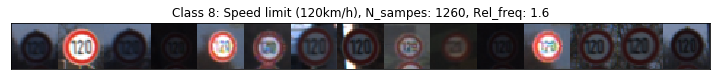

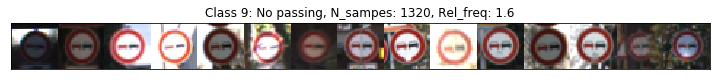

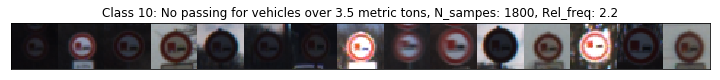

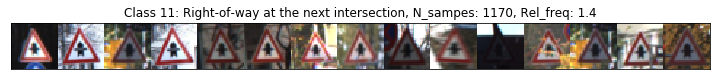

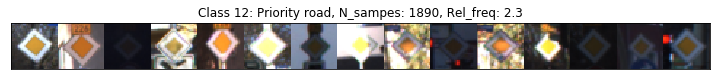

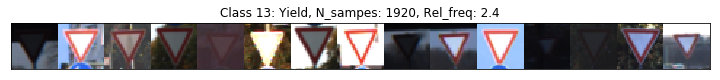

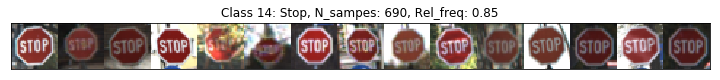

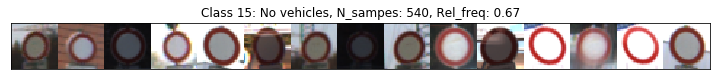

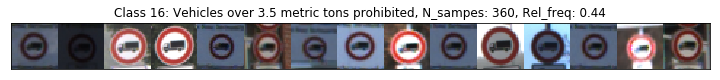

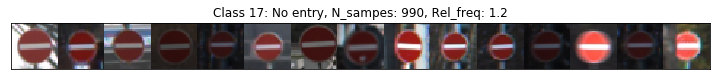

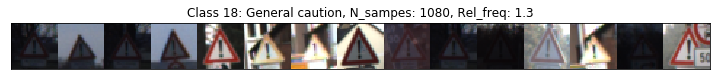

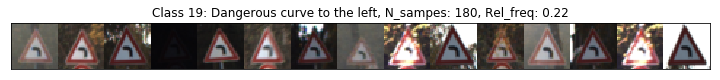

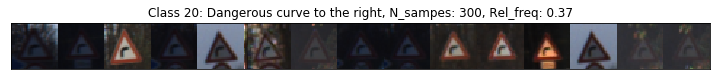

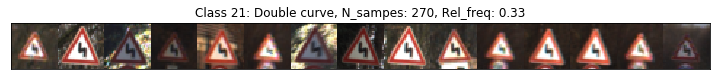

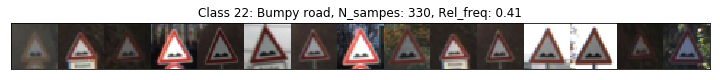

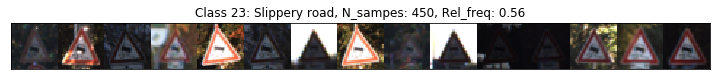

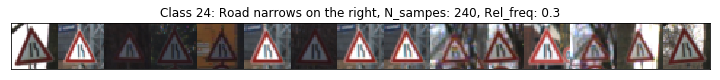

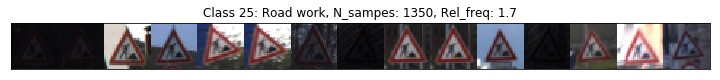

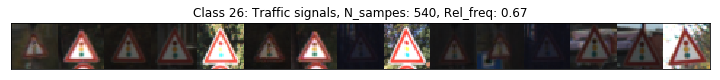

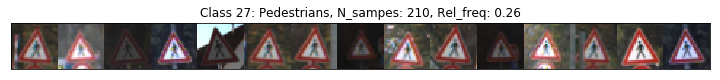

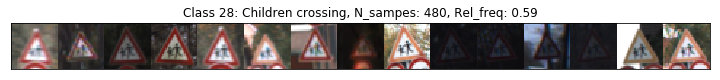

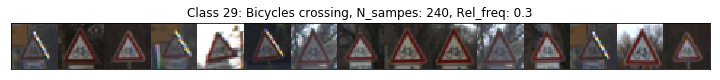

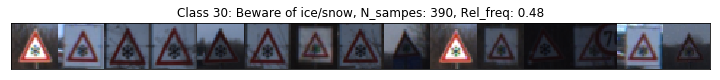

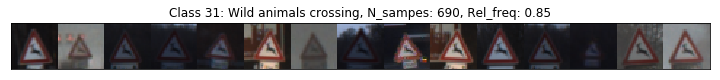

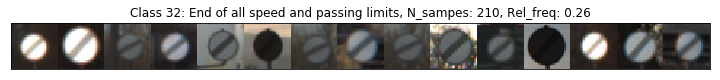

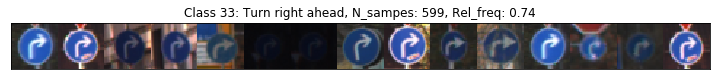

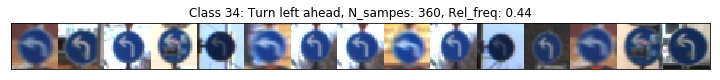

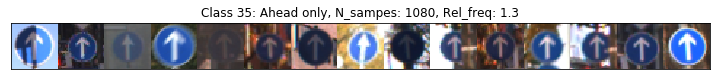

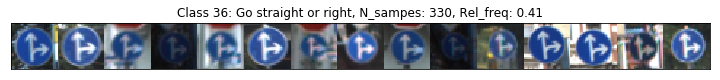

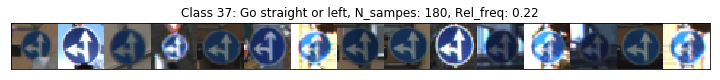

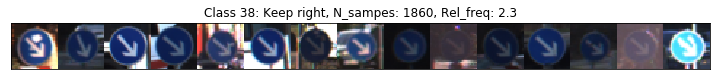

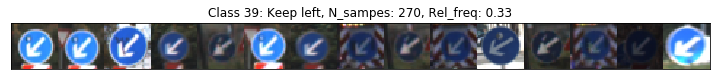

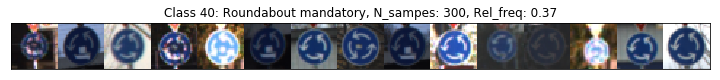

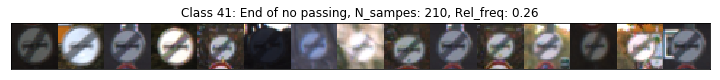

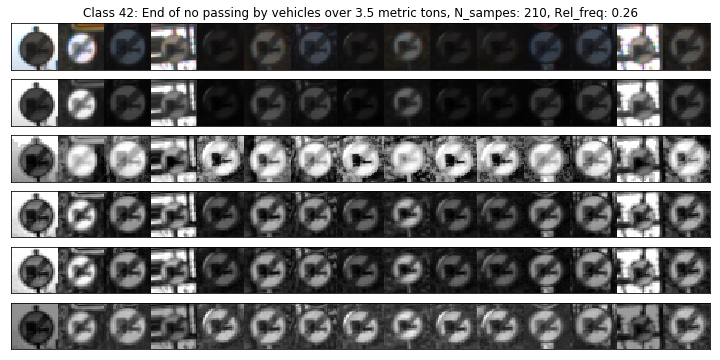

In [5]:
np.random.seed(1019)
N = n_classes
M = 15
img_canvas = []
img_canvas_gray = []
clahe = tu.DEFAULT_CLAHE
for i in range(n_classes):
    X_select = X_train[y_train == i]
    
    idx = np.random.choice(np.arange(X_select.shape[0]), M)
    img_canvas = np.concatenate(X_select[idx], axis=1)
    gray_images = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_select[idx]]
    img_canvas_gray = np.concatenate(gray_images, axis=1)
    
    gray_images_equ = [cv2.equalizeHist(x) for x in gray_images]
    img_canvas_equ = np.concatenate(gray_images_equ, axis=1)
    
    gray_images_Lequ = [clahe.apply(x) for x in gray_images]
    img_canvas_Lequ = np.concatenate(gray_images_Lequ, axis=1)
    
    gray_images_Lequ_normed = [(x-128.)/128 for x in gray_images_Lequ]
    img_canvas_Lequ_normed = np.concatenate(gray_images_Lequ_normed, axis=1)
    
    gray_images_Lequ_normed_v2 = [(x-x.mean())/x.std() for x in gray_images_Lequ]
    img_canvas_Lequ_normed_v2 = np.concatenate(gray_images_Lequ_normed_v2, axis=1)
    
    N = 6
    
    plt.figure(figsize=(20,6))
    plt.subplot(N,1,1)
    plt.imshow(img_canvas)
    plt.xticks([])
    plt.yticks([])
    plt.title('Class {}: {}, N_sampes: {}, Rel_freq: {:.2}'.format(i, sign_df.loc[i]['SignName'], sign_df.loc[i]['label_counts'],sign_df.loc[i]['label_freq_normed']))
    
    if i == n_classes-1:
        plt.subplot(N,1,2)
        plt.imshow(img_canvas_gray, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,3)
        plt.imshow(img_canvas_equ, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,4)
        plt.imshow(img_canvas_Lequ, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,5)
        plt.imshow(img_canvas_Lequ_normed, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,6)
        plt.imshow(img_canvas_Lequ_normed_v2, cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.show()


# Dataset augmentation

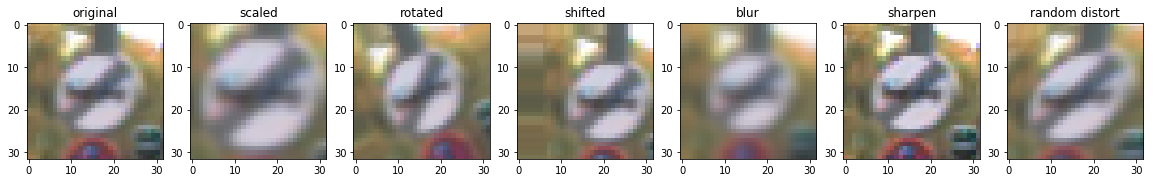

In [6]:
# demonstraing a set of functions for image transformation
test_img = X_train[100]
plt.figure(figsize=(20,10))
N = 7
i=1
plt.subplot(1, N, i)
plt.imshow(test_img)
plt.title('original')

i+=1
plt.subplot(1, N, i)
plt.imshow(tu.resize_img(test_img, scale=1.15))
plt.title('scaled')

i+=1
plt.subplot(1, N, i)
plt.imshow(tu.rotate_img(test_img, angle=25))
plt.title('rotated')

i+=1
plt.subplot(1, N, i)
plt.imshow(tu.shift_img(test_img, dx=5, dy=2))
plt.title('shifted')

i+=1
b, s = tu.blur_and_sharpen_img(test_img, kernel=(5,5), factor=0.8)
plt.subplot(1, N, i)
plt.imshow(b)
plt.title('blur')
i+=1
plt.subplot(1, N, i)
plt.imshow(s)
plt.title('sharpen')

i+=1
plt.subplot(1, N, i)
np.random.seed(1019)
plt.imshow(tu.distort_img(test_img, d_limit=5))
plt.title('random distort')

plt.show()

In [7]:
# merge X_train and X_valid

# print(X_train.shape)
# X_train = np.concatenate([X_train, X_valid], axis=0)
# print(X_train.shape)
# print(y_train.shape)
# y_train = np.concatenate([y_train, y_valid], axis=0)
# print(y_train.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

### Model Architecture

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [10]:
# Large LeNet5
model = tu.lenet
params = tu.params_big_lenet
#params['batch_norm'] = True
config = dict(model=model, model_params=params, resuming=True)

dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=False, aug_factor=1.0,
                        distort=True, resize=True, rotate=True, shift=True, blursharpen=True,
                        boost=False, target_y=[26, 21], use_grayscale=True, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.001)
#_ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
#_ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00,  9.81it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 119.46it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
(59788, 32, 32, 3) (59788,)
(7590, 32, 32, 3) (7590,)
Input shapes:  (59788, 32, 32, 3)
Using gray


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:16<00:00, 3684.67it/s]


Output shapes:  (59788, 32, 32, 4)
Input shapes:  (7590, 32, 32, 3)
Using gray


100%|████████████████████████████████████████████████████████████████████████████| 7590/7590 [00:02<00:00, 3728.98it/s]


Output shapes:  (7590, 32, 32, 4)
Input shapes:  (12630, 32, 32, 3)
Using gray


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:03<00:00, 3703.20it/s]


Output shapes:  (12630, 32, 32, 4)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet4__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
f83344cf98a37fb2
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\f83344cf98a37fb2
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 resh

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:11<00:00, 20.54it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00140326, accuracy: 99.98%
Validation loss: 0.06180977, accuracy: 98.31%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:20
      Timestamp: 2017/06/13 22:35:58


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.66it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00088393, accuracy: 99.98%
Validation loss: 0.09203676, accuracy: 98.43%
      Best loss: 0.06180977 at epoch 0
   Elapsed time: 00:00:35
      Timestamp: 2017/06/13 22:36:13


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.68it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00059109, accuracy: 99.99%
Validation loss: 0.06274996, accuracy: 98.37%
      Best loss: 0.06180977 at epoch 0
   Elapsed time: 00:00:49
      Timestamp: 2017/06/13 22:36:27


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.67it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00053667, accuracy: 99.99%
Validation loss: 0.05424592, accuracy: 98.71%
      Best loss: 0.06180977 at epoch 0
   Elapsed time: 00:01:03
      Timestamp: 2017/06/13 22:36:42


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.64it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00031200, accuracy: 100.00%
Validation loss: 0.07455785, accuracy: 98.46%
      Best loss: 0.05424592 at epoch 3
   Elapsed time: 00:01:18
      Timestamp: 2017/06/13 22:36:57


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.56it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00049816, accuracy: 99.98%
Validation loss: 0.05822221, accuracy: 98.66%
      Best loss: 0.05424592 at epoch 3
   Elapsed time: 00:01:33
      Timestamp: 2017/06/13 22:37:11


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.61it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00092058, accuracy: 99.99%
Validation loss: 0.04572088, accuracy: 98.75%
      Best loss: 0.05424592 at epoch 3
   Elapsed time: 00:01:47
      Timestamp: 2017/06/13 22:37:25


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.58it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00044288, accuracy: 99.99%
Validation loss: 0.07380196, accuracy: 98.21%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:02:02
      Timestamp: 2017/06/13 22:37:40


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.59it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00022454, accuracy: 100.00%
Validation loss: 0.07066532, accuracy: 98.45%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:02:16
      Timestamp: 2017/06/13 22:37:55


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.58it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00023477, accuracy: 100.00%
Validation loss: 0.09784830, accuracy: 98.27%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:02:31
      Timestamp: 2017/06/13 22:38:09


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.60it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00046057, accuracy: 99.99%
Validation loss: 0.06174217, accuracy: 98.38%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:02:45
      Timestamp: 2017/06/13 22:38:23


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.58it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00019150, accuracy: 100.00%
Validation loss: 0.06470322, accuracy: 98.67%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:02:59
      Timestamp: 2017/06/13 22:38:38


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.55it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00071128, accuracy: 99.98%
Validation loss: 0.06588521, accuracy: 98.66%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:03:14
      Timestamp: 2017/06/13 22:38:52


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.60it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00010161, accuracy: 100.00%
Validation loss: 0.05894765, accuracy: 98.33%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:03:28
      Timestamp: 2017/06/13 22:39:06


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.59it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00016407, accuracy: 100.00%
Validation loss: 0.05584155, accuracy: 98.79%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:03:43
      Timestamp: 2017/06/13 22:39:21


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.60it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00009142, accuracy: 100.00%
Validation loss: 0.05121340, accuracy: 98.63%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:03:57
      Timestamp: 2017/06/13 22:39:35


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.61it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00020464, accuracy: 99.99%
Validation loss: 0.06503608, accuracy: 98.70%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:04:11
      Timestamp: 2017/06/13 22:39:49


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:10<00:00, 22.62it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00025550, accuracy: 99.99%
Validation loss: 0.06027306, accuracy: 98.43%
      Best loss: 0.04572088 at epoch 6
   Elapsed time: 00:04:25
      Timestamp: 2017/06/13 22:40:04
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\f83344cf98a37fb2\best_epoch
Early stopping.
Best monitored loss was 0.04572088 at epoch 6.
 Valid loss: 0.04572088, accuracy = 98.75%)
 Test loss: 0.12776501, accuracy = 96.85%)
 Total time: 00:04:27
  Timestamp: 2017/06/13 22:40:05
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\f83344cf98a37fb2\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\f83344cf98a37fb2\training_history.npz


In [11]:
import gc
gc.collect()
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=1.0,
                        distort=True, resize=False, rotate=False, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=1.0,
                        distort=False, resize=True, rotate=False, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=1.0,
                        distort=False, resize=False, rotate=True, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=1.0,
                        distort=False, resize=False, rotate=False, shift=True, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=1.0,
                        distort=False, resize=False, rotate=False, shift=False, blursharpen=True,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)

Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 10.10it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 118.62it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = True
resize = False
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:04<00:00, 13408.76it/s]


Output shapes:  (179364, 32, 32, 3) (179364,)
========= augment_data() arguments: =========
distort = True
resize = False
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 12338.75it/s]


Output shapes:  (22770, 32, 32, 3) (22770,)
(179364, 32, 32, 3) (179364,)
(22770, 32, 32, 3) (22770,)
Input shapes:  (179364, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 179364/179364 [01:07<00:00, 2646.78it/s]


Output shapes:  (179364, 32, 32, 6)
Input shapes:  (22770, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 22770/22770 [00:08<00:00, 2665.74it/s]


Output shapes:  (22770, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2658.31it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.90it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.95925030, accuracy: 75.41%
Validation loss: 1.11460576, accuracy: 70.77%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:51
      Timestamp: 2017/06/13 22:43:08


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:36<00:00, 19.36it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.48040439, accuracy: 87.48%
Validation loss: 0.64418535, accuracy: 81.49%
      Best loss: 1.11460576 at epoch 0
   Elapsed time: 00:01:43
      Timestamp: 2017/06/13 22:44:00


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.00it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.27098666, accuracy: 92.91%
Validation loss: 0.43575335, accuracy: 86.89%
      Best loss: 0.64418535 at epoch 1
   Elapsed time: 00:02:36
      Timestamp: 2017/06/13 22:44:52


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.89it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.16711118, accuracy: 95.76%
Validation loss: 0.34382983, accuracy: 89.73%
      Best loss: 0.43575335 at epoch 2
   Elapsed time: 00:03:28
      Timestamp: 2017/06/13 22:45:44


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.49it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.10943472, accuracy: 97.24%
Validation loss: 0.27371232, accuracy: 92.00%
      Best loss: 0.34382983 at epoch 3
   Elapsed time: 00:04:20
      Timestamp: 2017/06/13 22:46:36


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.94it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.07553601, accuracy: 98.17%
Validation loss: 0.23818865, accuracy: 93.09%
      Best loss: 0.27371232 at epoch 4
   Elapsed time: 00:05:10
      Timestamp: 2017/06/13 22:47:27


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.01it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.05394830, accuracy: 98.68%
Validation loss: 0.21205435, accuracy: 93.78%
      Best loss: 0.23818865 at epoch 5
   Elapsed time: 00:06:01
      Timestamp: 2017/06/13 22:48:17


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.96it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.04128870, accuracy: 99.01%
Validation loss: 0.19589795, accuracy: 94.13%
      Best loss: 0.21205435 at epoch 6
   Elapsed time: 00:06:51
      Timestamp: 2017/06/13 22:49:08


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.02it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.03152016, accuracy: 99.24%
Validation loss: 0.18408938, accuracy: 94.58%
      Best loss: 0.19589795 at epoch 7
   Elapsed time: 00:07:41
      Timestamp: 2017/06/13 22:49:58


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.96it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.02467733, accuracy: 99.44%
Validation loss: 0.16963752, accuracy: 95.02%
      Best loss: 0.18408938 at epoch 8
   Elapsed time: 00:08:32
      Timestamp: 2017/06/13 22:50:49


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.75it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.01903773, accuracy: 99.56%
Validation loss: 0.17497675, accuracy: 95.09%
      Best loss: 0.16963752 at epoch 9
   Elapsed time: 00:09:23
      Timestamp: 2017/06/13 22:51:40


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.56it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.01521344, accuracy: 99.69%
Validation loss: 0.15957366, accuracy: 95.52%
      Best loss: 0.16963752 at epoch 9
   Elapsed time: 00:10:14
      Timestamp: 2017/06/13 22:52:31


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.96it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.01167360, accuracy: 99.77%
Validation loss: 0.14997399, accuracy: 95.72%
      Best loss: 0.15957366 at epoch 11
   Elapsed time: 00:11:06
      Timestamp: 2017/06/13 22:53:22


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.52it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00988241, accuracy: 99.81%
Validation loss: 0.15405197, accuracy: 95.68%
      Best loss: 0.14997399 at epoch 12
   Elapsed time: 00:11:57
      Timestamp: 2017/06/13 22:54:14


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.00it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00785173, accuracy: 99.86%
Validation loss: 0.15140844, accuracy: 95.92%
      Best loss: 0.14997399 at epoch 12
   Elapsed time: 00:12:48
      Timestamp: 2017/06/13 22:55:05


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.73it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00601974, accuracy: 99.91%
Validation loss: 0.14099832, accuracy: 96.32%
      Best loss: 0.14997399 at epoch 12
   Elapsed time: 00:13:38
      Timestamp: 2017/06/13 22:55:55


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.00it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00516409, accuracy: 99.91%
Validation loss: 0.15018194, accuracy: 96.12%
      Best loss: 0.14099832 at epoch 15
   Elapsed time: 00:14:29
      Timestamp: 2017/06/13 22:56:46


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.82it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00400509, accuracy: 99.93%
Validation loss: 0.13765506, accuracy: 96.53%
      Best loss: 0.14099832 at epoch 15
   Elapsed time: 00:15:19
      Timestamp: 2017/06/13 22:57:36


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.98it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00323179, accuracy: 99.95%
Validation loss: 0.14265046, accuracy: 96.46%
      Best loss: 0.13765506 at epoch 17
   Elapsed time: 00:16:09
      Timestamp: 2017/06/13 22:58:26


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.97it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00257578, accuracy: 99.96%
Validation loss: 0.13701845, accuracy: 96.56%
      Best loss: 0.13765506 at epoch 17
   Elapsed time: 00:16:59
      Timestamp: 2017/06/13 22:59:16


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.97it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00234568, accuracy: 99.97%
Validation loss: 0.15080014, accuracy: 96.45%
      Best loss: 0.13701845 at epoch 19
   Elapsed time: 00:17:50
      Timestamp: 2017/06/13 23:00:06


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.97it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00196715, accuracy: 99.98%
Validation loss: 0.14556428, accuracy: 96.59%
      Best loss: 0.13701845 at epoch 19
   Elapsed time: 00:18:39
      Timestamp: 2017/06/13 23:00:56


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.99it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00146691, accuracy: 99.99%
Validation loss: 0.14094606, accuracy: 96.79%
      Best loss: 0.13701845 at epoch 19
   Elapsed time: 00:19:29
      Timestamp: 2017/06/13 23:01:46


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.99it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00161903, accuracy: 99.98%
Validation loss: 0.13939447, accuracy: 96.79%
      Best loss: 0.13701845 at epoch 19
   Elapsed time: 00:20:19
      Timestamp: 2017/06/13 23:02:36


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.97it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00113925, accuracy: 99.99%
Validation loss: 0.12454937, accuracy: 96.96%
      Best loss: 0.13701845 at epoch 19
   Elapsed time: 00:21:08
      Timestamp: 2017/06/13 23:03:25


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.01it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00095435, accuracy: 99.99%
Validation loss: 0.15070242, accuracy: 96.90%
      Best loss: 0.12454937 at epoch 24
   Elapsed time: 00:21:59
      Timestamp: 2017/06/13 23:04:16


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.92it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00080650, accuracy: 99.99%
Validation loss: 0.14243580, accuracy: 96.94%
      Best loss: 0.12454937 at epoch 24
   Elapsed time: 00:22:48
      Timestamp: 2017/06/13 23:05:05


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.99it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00059684, accuracy: 100.00%
Validation loss: 0.14170067, accuracy: 97.00%
      Best loss: 0.12454937 at epoch 24
   Elapsed time: 00:23:38
      Timestamp: 2017/06/13 23:05:55


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.96it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00052725, accuracy: 100.00%
Validation loss: 0.12035523, accuracy: 97.27%
      Best loss: 0.12454937 at epoch 24
   Elapsed time: 00:24:28
      Timestamp: 2017/06/13 23:06:45


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.01it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00060494, accuracy: 100.00%
Validation loss: 0.14611593, accuracy: 96.85%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:25:18
      Timestamp: 2017/06/13 23:07:35


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.99it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00046156, accuracy: 100.00%
Validation loss: 0.14175624, accuracy: 96.95%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:26:08
      Timestamp: 2017/06/13 23:08:25


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.97it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00039540, accuracy: 100.00%
Validation loss: 0.14805296, accuracy: 97.12%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:26:58
      Timestamp: 2017/06/13 23:09:15


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.98it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00033113, accuracy: 100.00%
Validation loss: 0.13419287, accuracy: 97.12%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:27:47
      Timestamp: 2017/06/13 23:10:04


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.98it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00030050, accuracy: 100.00%
Validation loss: 0.13979942, accuracy: 97.06%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:28:37
      Timestamp: 2017/06/13 23:10:54


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.94it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00027993, accuracy: 100.00%
Validation loss: 0.13495399, accuracy: 97.18%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:29:27
      Timestamp: 2017/06/13 23:11:44


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.02it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00028095, accuracy: 100.00%
Validation loss: 0.14127633, accuracy: 97.18%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:30:17
      Timestamp: 2017/06/13 23:12:33


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.92it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00021087, accuracy: 100.00%
Validation loss: 0.12236348, accuracy: 97.29%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:31:06
      Timestamp: 2017/06/13 23:13:23


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.91it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00018445, accuracy: 100.00%
Validation loss: 0.13900579, accuracy: 97.41%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:31:56
      Timestamp: 2017/06/13 23:14:13


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.98it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00018676, accuracy: 100.00%
Validation loss: 0.14656047, accuracy: 97.26%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:32:46
      Timestamp: 2017/06/13 23:15:03


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.98it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00013638, accuracy: 100.00%
Validation loss: 0.13574650, accuracy: 97.39%
      Best loss: 0.12035523 at epoch 28
   Elapsed time: 00:33:35
      Timestamp: 2017/06/13 23:15:52
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.12035523 at epoch 28.
 Valid loss: 0.12035523, accuracy = 97.27%)
 Test loss: 0.11819853, accuracy = 97.05%)
 Total time: 00:33:38
  Timestamp: 2017/06/13 23:15:55
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00,  9.95it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 117.01it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = True
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:08<00:00, 6885.58it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = True
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|████████████████████████████████████████████████████████████████████████████| 7590/7590 [00:01<00:00, 7124.29it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:52<00:00, 2650.12it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2623.04it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2592.39it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 16.85it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00353137, accuracy: 99.92%
Validation loss: 0.10499626, accuracy: 97.44%
      Best loss: inf at epoch 0
   Elapsed time: 00:02:09
      Timestamp: 2017/06/13 23:23:58


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:11<00:00, 16.45it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00177899, accuracy: 99.97%
Validation loss: 0.09367524, accuracy: 97.63%
      Best loss: 0.10499626 at epoch 0
   Elapsed time: 00:04:18
      Timestamp: 2017/06/13 23:26:07


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 19.29it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00098369, accuracy: 99.98%
Validation loss: 0.09643788, accuracy: 97.77%
      Best loss: 0.09367524 at epoch 1
   Elapsed time: 00:05:54
      Timestamp: 2017/06/13 23:27:42


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.83it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00083815, accuracy: 99.98%
Validation loss: 0.10038654, accuracy: 97.89%
      Best loss: 0.09367524 at epoch 1
   Elapsed time: 00:07:17
      Timestamp: 2017/06/13 23:29:06


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.55it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00048237, accuracy: 99.99%
Validation loss: 0.08653388, accuracy: 98.05%
      Best loss: 0.09367524 at epoch 1
   Elapsed time: 00:08:44
      Timestamp: 2017/06/13 23:30:33


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.51it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00047730, accuracy: 99.99%
Validation loss: 0.08422153, accuracy: 98.03%
      Best loss: 0.08653388 at epoch 4
   Elapsed time: 00:10:11
      Timestamp: 2017/06/13 23:32:00


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.50it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00029164, accuracy: 100.00%
Validation loss: 0.08686150, accuracy: 98.04%
      Best loss: 0.08422153 at epoch 5
   Elapsed time: 00:11:38
      Timestamp: 2017/06/13 23:33:27


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.53it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00018215, accuracy: 100.00%
Validation loss: 0.08465881, accuracy: 98.10%
      Best loss: 0.08422153 at epoch 5
   Elapsed time: 00:13:05
      Timestamp: 2017/06/13 23:34:53


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.46it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00020177, accuracy: 100.00%
Validation loss: 0.08951435, accuracy: 98.09%
      Best loss: 0.08422153 at epoch 5
   Elapsed time: 00:14:31
      Timestamp: 2017/06/13 23:36:20


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.60it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00010988, accuracy: 100.00%
Validation loss: 0.08709040, accuracy: 98.12%
      Best loss: 0.08422153 at epoch 5
   Elapsed time: 00:15:58
      Timestamp: 2017/06/13 23:37:46


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.82it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00009046, accuracy: 100.00%
Validation loss: 0.08740943, accuracy: 98.09%
      Best loss: 0.08422153 at epoch 5
   Elapsed time: 00:17:24
      Timestamp: 2017/06/13 23:39:13


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.57it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00007577, accuracy: 100.00%
Validation loss: 0.07675997, accuracy: 98.28%
      Best loss: 0.08422153 at epoch 5
   Elapsed time: 00:18:50
      Timestamp: 2017/06/13 23:40:39


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.60it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00005691, accuracy: 100.00%
Validation loss: 0.08105359, accuracy: 98.30%
      Best loss: 0.07675997 at epoch 11
   Elapsed time: 00:20:17
      Timestamp: 2017/06/13 23:42:06


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.50it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00006443, accuracy: 100.00%
Validation loss: 0.08072509, accuracy: 98.34%
      Best loss: 0.07675997 at epoch 11
   Elapsed time: 00:21:44
      Timestamp: 2017/06/13 23:43:33


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.56it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00003877, accuracy: 100.00%
Validation loss: 0.09017833, accuracy: 98.32%
      Best loss: 0.07675997 at epoch 11
   Elapsed time: 00:23:10
      Timestamp: 2017/06/13 23:44:59


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.56it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00003321, accuracy: 100.00%
Validation loss: 0.07490993, accuracy: 98.50%
      Best loss: 0.07675997 at epoch 11
   Elapsed time: 00:24:37
      Timestamp: 2017/06/13 23:46:26


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.55it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00003336, accuracy: 100.00%
Validation loss: 0.09546939, accuracy: 98.30%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:26:04
      Timestamp: 2017/06/13 23:47:53


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.54it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00002792, accuracy: 100.00%
Validation loss: 0.07896228, accuracy: 98.45%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:27:30
      Timestamp: 2017/06/13 23:49:19


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.53it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00001942, accuracy: 100.00%
Validation loss: 0.09672592, accuracy: 98.29%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:28:57
      Timestamp: 2017/06/13 23:50:45


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.55it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00002222, accuracy: 100.00%
Validation loss: 0.08615849, accuracy: 98.40%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:30:23
      Timestamp: 2017/06/13 23:52:12


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.53it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00001504, accuracy: 100.00%
Validation loss: 0.08859862, accuracy: 98.36%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:31:49
      Timestamp: 2017/06/13 23:53:38


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.58it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00001618, accuracy: 100.00%
Validation loss: 0.08509459, accuracy: 98.34%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:33:16
      Timestamp: 2017/06/13 23:55:04


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.51it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00000875, accuracy: 100.00%
Validation loss: 0.08282532, accuracy: 98.48%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:34:42
      Timestamp: 2017/06/13 23:56:31


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.56it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00001150, accuracy: 100.00%
Validation loss: 0.08439656, accuracy: 98.36%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:36:09
      Timestamp: 2017/06/13 23:57:57


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.56it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00001144, accuracy: 100.00%
Validation loss: 0.09040519, accuracy: 98.46%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:37:35
      Timestamp: 2017/06/13 23:59:24


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.55it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00001724, accuracy: 100.00%
Validation loss: 0.08453233, accuracy: 98.39%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:39:01
      Timestamp: 2017/06/14 00:00:50


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.52it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00000783, accuracy: 100.00%
Validation loss: 0.08739506, accuracy: 98.38%
      Best loss: 0.07490993 at epoch 15
   Elapsed time: 00:40:28
      Timestamp: 2017/06/14 00:02:17
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.07490993 at epoch 15.
 Valid loss: 0.07490993, accuracy = 98.50%)
 Test loss: 0.07424247, accuracy = 98.08%)
 Total time: 00:40:34
  Timestamp: 2017/06/14 00:02:22
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.23it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 99.26it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = True
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:04<00:00, 13920.56it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = True
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 14813.74it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:53<00:00, 2629.97it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2592.63it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2567.82it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:07<00:00, 17.35it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00075664, accuracy: 99.98%
Validation loss: 0.10319981, accuracy: 98.21%
      Best loss: inf at epoch 0
   Elapsed time: 00:02:04
      Timestamp: 2017/06/14 00:10:13


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:08<00:00, 16.97it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00035867, accuracy: 99.99%
Validation loss: 0.10158137, accuracy: 98.23%
      Best loss: 0.10319981 at epoch 0
   Elapsed time: 00:04:13
      Timestamp: 2017/06/14 00:12:22


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:12<00:00, 16.12it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00015598, accuracy: 100.00%
Validation loss: 0.10166638, accuracy: 98.30%
      Best loss: 0.10158137 at epoch 1
   Elapsed time: 00:06:03
      Timestamp: 2017/06/14 00:14:12


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.48it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00008335, accuracy: 100.00%
Validation loss: 0.10224421, accuracy: 98.37%
      Best loss: 0.10158137 at epoch 1
   Elapsed time: 00:07:31
      Timestamp: 2017/06/14 00:15:39


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.48it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00006622, accuracy: 100.00%
Validation loss: 0.10938111, accuracy: 98.50%
      Best loss: 0.10158137 at epoch 1
   Elapsed time: 00:08:57
      Timestamp: 2017/06/14 00:17:06


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.49it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00006027, accuracy: 100.00%
Validation loss: 0.10335230, accuracy: 98.34%
      Best loss: 0.10158137 at epoch 1
   Elapsed time: 00:10:24
      Timestamp: 2017/06/14 00:18:33


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 19.46it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00005143, accuracy: 100.00%
Validation loss: 0.09084407, accuracy: 98.43%
      Best loss: 0.10158137 at epoch 1
   Elapsed time: 00:11:51
      Timestamp: 2017/06/14 00:19:59


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.58it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00002947, accuracy: 100.00%
Validation loss: 0.09664225, accuracy: 98.33%
      Best loss: 0.09084407 at epoch 6
   Elapsed time: 00:13:19
      Timestamp: 2017/06/14 00:21:27


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 19.46it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00002360, accuracy: 100.00%
Validation loss: 0.10298082, accuracy: 98.32%
      Best loss: 0.09084407 at epoch 6
   Elapsed time: 00:14:46
      Timestamp: 2017/06/14 00:22:54


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.51it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00001804, accuracy: 100.00%
Validation loss: 0.11083920, accuracy: 98.27%
      Best loss: 0.09084407 at epoch 6
   Elapsed time: 00:16:12
      Timestamp: 2017/06/14 00:24:21


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.50it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00001775, accuracy: 100.00%
Validation loss: 0.08515106, accuracy: 98.48%
      Best loss: 0.09084407 at epoch 6
   Elapsed time: 00:17:39
      Timestamp: 2017/06/14 00:25:47


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.83it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00001353, accuracy: 100.00%
Validation loss: 0.10263796, accuracy: 98.48%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:19:06
      Timestamp: 2017/06/14 00:27:14


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.53it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00001831, accuracy: 100.00%
Validation loss: 0.12289612, accuracy: 98.24%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:20:32
      Timestamp: 2017/06/14 00:28:41


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.47it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00000611, accuracy: 100.00%
Validation loss: 0.10523711, accuracy: 98.30%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:21:59
      Timestamp: 2017/06/14 00:30:07


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.50it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00000570, accuracy: 100.00%
Validation loss: 0.12077697, accuracy: 98.36%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:23:25
      Timestamp: 2017/06/14 00:31:34


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.52it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00000585, accuracy: 100.00%
Validation loss: 0.11312828, accuracy: 98.51%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:24:52
      Timestamp: 2017/06/14 00:33:01


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.47it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00000398, accuracy: 100.00%
Validation loss: 0.12858565, accuracy: 98.48%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:26:19
      Timestamp: 2017/06/14 00:34:27


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.48it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00000334, accuracy: 100.00%
Validation loss: 0.12681641, accuracy: 98.45%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:27:45
      Timestamp: 2017/06/14 00:35:54


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.49it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00000317, accuracy: 100.00%
Validation loss: 0.10806336, accuracy: 98.52%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:29:12
      Timestamp: 2017/06/14 00:37:20


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.55it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00000280, accuracy: 100.00%
Validation loss: 0.12462641, accuracy: 98.47%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:30:38
      Timestamp: 2017/06/14 00:38:47


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.50it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00000277, accuracy: 100.00%
Validation loss: 0.11521660, accuracy: 98.54%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:32:05
      Timestamp: 2017/06/14 00:40:13


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.49it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00000179, accuracy: 100.00%
Validation loss: 0.13253259, accuracy: 98.48%
      Best loss: 0.08515106 at epoch 10
   Elapsed time: 00:33:31
      Timestamp: 2017/06/14 00:41:40
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.08515106 at epoch 10.
 Valid loss: 0.08515106, accuracy = 98.48%)
 Test loss: 0.08515861, accuracy = 98.11%)
 Total time: 00:33:37
  Timestamp: 2017/06/14 00:41:46
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.39it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 96.79it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = True
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:06<00:00, 9923.18it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = True
blursharpen = False
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 12636.80it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:55<00:00, 2589.13it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2622.48it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2607.11it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:05<00:00, 17.82it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00521535, accuracy: 99.88%
Validation loss: 0.11409957, accuracy: 97.42%
      Best loss: inf at epoch 0
   Elapsed time: 00:02:08
      Timestamp: 2017/06/14 00:49:40


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:01<00:00, 20.84it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00241111, accuracy: 99.95%
Validation loss: 0.10071026, accuracy: 97.85%
      Best loss: 0.11409957 at epoch 0
   Elapsed time: 00:03:56
      Timestamp: 2017/06/14 00:51:28


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:10<00:00, 16.54it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00134066, accuracy: 99.98%
Validation loss: 0.10480837, accuracy: 97.99%
      Best loss: 0.10071026 at epoch 1
   Elapsed time: 00:05:36
      Timestamp: 2017/06/14 00:53:07


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 20.88it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00084420, accuracy: 99.99%
Validation loss: 0.10110400, accuracy: 98.09%
      Best loss: 0.10071026 at epoch 1
   Elapsed time: 00:07:04
      Timestamp: 2017/06/14 00:54:36


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.49it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00056044, accuracy: 99.99%
Validation loss: 0.10391806, accuracy: 98.17%
      Best loss: 0.10071026 at epoch 1
   Elapsed time: 00:08:31
      Timestamp: 2017/06/14 00:56:03


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.86it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00040609, accuracy: 100.00%
Validation loss: 0.10660677, accuracy: 98.31%
      Best loss: 0.10071026 at epoch 1
   Elapsed time: 00:09:58
      Timestamp: 2017/06/14 00:57:30


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.62it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00035460, accuracy: 100.00%
Validation loss: 0.09504451, accuracy: 98.28%
      Best loss: 0.10071026 at epoch 1
   Elapsed time: 00:11:27
      Timestamp: 2017/06/14 00:58:58


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.83it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00022283, accuracy: 100.00%
Validation loss: 0.09899563, accuracy: 98.15%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:12:55
      Timestamp: 2017/06/14 01:00:27


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.89it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00016636, accuracy: 100.00%
Validation loss: 0.09730872, accuracy: 98.30%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:14:20
      Timestamp: 2017/06/14 01:01:52


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:01<00:00, 20.79it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00013427, accuracy: 100.00%
Validation loss: 0.09977112, accuracy: 98.21%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:15:48
      Timestamp: 2017/06/14 01:03:20


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.89it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00009882, accuracy: 100.00%
Validation loss: 0.10525844, accuracy: 98.47%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:17:13
      Timestamp: 2017/06/14 01:04:45


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 20.67it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00007357, accuracy: 100.00%
Validation loss: 0.11015375, accuracy: 98.23%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:18:39
      Timestamp: 2017/06/14 01:06:11


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.87it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00006090, accuracy: 100.00%
Validation loss: 0.10434590, accuracy: 98.43%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:20:04
      Timestamp: 2017/06/14 01:07:36


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.24it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00005081, accuracy: 100.00%
Validation loss: 0.10430906, accuracy: 98.41%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:21:29
      Timestamp: 2017/06/14 01:09:01


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.11it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00004393, accuracy: 100.00%
Validation loss: 0.09511259, accuracy: 98.48%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:22:53
      Timestamp: 2017/06/14 01:10:25


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.07it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00004169, accuracy: 100.00%
Validation loss: 0.11296235, accuracy: 98.26%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:24:18
      Timestamp: 2017/06/14 01:11:49


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.05it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00003941, accuracy: 100.00%
Validation loss: 0.10244882, accuracy: 98.32%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:25:42
      Timestamp: 2017/06/14 01:13:14


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.07it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00002457, accuracy: 100.00%
Validation loss: 0.09916095, accuracy: 98.46%
      Best loss: 0.09504451 at epoch 6
   Elapsed time: 00:27:07
      Timestamp: 2017/06/14 01:14:38
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.09504451 at epoch 6.
 Valid loss: 0.09504451, accuracy = 98.28%)
 Test loss: 0.07709039, accuracy = 98.12%)
 Total time: 00:27:13
  Timestamp: 2017/06/14 01:14:44
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.51it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 99.42it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = False
blursharpen = True
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:01<00:00, 56590.62it/s]


Output shapes:  (179364, 32, 32, 3) (179364,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = False
blursharpen = True
N_copy = 1
target_y = None
factor = 1.0
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 69442.88it/s]


Output shapes:  (22770, 32, 32, 3) (22770,)
(179364, 32, 32, 3) (179364,)
(22770, 32, 32, 3) (22770,)
Input shapes:  (179364, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 179364/179364 [01:05<00:00, 2723.50it/s]


Output shapes:  (179364, 32, 32, 6)
Input shapes:  (22770, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 22770/22770 [00:08<00:00, 2683.88it/s]


Output shapes:  (22770, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2636.76it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.35it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00001454, accuracy: 100.00%
Validation loss: 0.10207722, accuracy: 98.83%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:56
      Timestamp: 2017/06/14 01:18:09


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.40it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00000834, accuracy: 100.00%
Validation loss: 0.11526684, accuracy: 98.67%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:01:46
      Timestamp: 2017/06/14 01:18:59


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00000455, accuracy: 100.00%
Validation loss: 0.10670374, accuracy: 98.66%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:02:34
      Timestamp: 2017/06/14 01:19:48


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00000263, accuracy: 100.00%
Validation loss: 0.11844158, accuracy: 98.54%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:03:23
      Timestamp: 2017/06/14 01:20:36


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00000507, accuracy: 100.00%
Validation loss: 0.10484103, accuracy: 98.60%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:04:12
      Timestamp: 2017/06/14 01:21:25


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00000822, accuracy: 100.00%
Validation loss: 0.11066948, accuracy: 98.55%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:05:01
      Timestamp: 2017/06/14 01:22:14


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.36it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00000194, accuracy: 100.00%
Validation loss: 0.10284639, accuracy: 98.56%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:05:49
      Timestamp: 2017/06/14 01:23:03


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.40it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00000083, accuracy: 100.00%
Validation loss: 0.10768385, accuracy: 98.63%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:06:38
      Timestamp: 2017/06/14 01:23:51


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.42it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00000577, accuracy: 100.00%
Validation loss: 0.11799922, accuracy: 98.68%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:07:27
      Timestamp: 2017/06/14 01:24:40


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000110, accuracy: 100.00%
Validation loss: 0.10195079, accuracy: 98.74%
      Best loss: 0.10207722 at epoch 0
   Elapsed time: 00:08:16
      Timestamp: 2017/06/14 01:25:29


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00000167, accuracy: 100.00%
Validation loss: 0.09320351, accuracy: 98.77%
      Best loss: 0.10195079 at epoch 9
   Elapsed time: 00:09:05
      Timestamp: 2017/06/14 01:26:18


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.46it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000118, accuracy: 100.00%
Validation loss: 0.10303048, accuracy: 98.67%
      Best loss: 0.09320351 at epoch 10
   Elapsed time: 00:09:55
      Timestamp: 2017/06/14 01:27:08


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00000062, accuracy: 100.00%
Validation loss: 0.12757809, accuracy: 98.61%
      Best loss: 0.09320351 at epoch 10
   Elapsed time: 00:10:43
      Timestamp: 2017/06/14 01:27:57


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00000154, accuracy: 100.00%
Validation loss: 0.11821862, accuracy: 98.67%
      Best loss: 0.09320351 at epoch 10
   Elapsed time: 00:11:32
      Timestamp: 2017/06/14 01:28:45


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00000034, accuracy: 100.00%
Validation loss: 0.13790405, accuracy: 98.79%
      Best loss: 0.09320351 at epoch 10
   Elapsed time: 00:12:21
      Timestamp: 2017/06/14 01:29:34


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00000096, accuracy: 100.00%
Validation loss: 0.13251631, accuracy: 98.70%
      Best loss: 0.09320351 at epoch 10
   Elapsed time: 00:13:10
      Timestamp: 2017/06/14 01:30:23


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.38it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00000017, accuracy: 100.00%
Validation loss: 0.13042029, accuracy: 98.72%
      Best loss: 0.09320351 at epoch 10
   Elapsed time: 00:13:59
      Timestamp: 2017/06/14 01:31:12


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00000074, accuracy: 100.00%
Validation loss: 0.09124995, accuracy: 98.92%
      Best loss: 0.09320351 at epoch 10
   Elapsed time: 00:14:47
      Timestamp: 2017/06/14 01:32:01


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00000188, accuracy: 100.00%
Validation loss: 0.12337968, accuracy: 98.78%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:15:37
      Timestamp: 2017/06/14 01:32:50


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00000033, accuracy: 100.00%
Validation loss: 0.11589244, accuracy: 98.73%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:16:26
      Timestamp: 2017/06/14 01:33:39


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00000021, accuracy: 100.00%
Validation loss: 0.09618572, accuracy: 98.81%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:17:14
      Timestamp: 2017/06/14 01:34:28


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.41it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00000050, accuracy: 100.00%
Validation loss: 0.12873721, accuracy: 98.59%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:18:03
      Timestamp: 2017/06/14 01:35:17


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00000011, accuracy: 100.00%
Validation loss: 0.12176773, accuracy: 98.81%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:18:52
      Timestamp: 2017/06/14 01:36:05


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00000009, accuracy: 100.00%
Validation loss: 0.10941969, accuracy: 98.80%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:19:41
      Timestamp: 2017/06/14 01:36:54


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.40it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00000022, accuracy: 100.00%
Validation loss: 0.12596423, accuracy: 98.62%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:20:30
      Timestamp: 2017/06/14 01:37:43


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00000044, accuracy: 100.00%
Validation loss: 0.11548408, accuracy: 98.65%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:21:18
      Timestamp: 2017/06/14 01:38:32


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00000009, accuracy: 100.00%
Validation loss: 0.12839289, accuracy: 98.53%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:22:07
      Timestamp: 2017/06/14 01:39:20


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.48it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00000017, accuracy: 100.00%
Validation loss: 0.10827265, accuracy: 98.73%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:22:56
      Timestamp: 2017/06/14 01:40:09


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.44it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00000010, accuracy: 100.00%
Validation loss: 0.09467976, accuracy: 98.83%
      Best loss: 0.09124995 at epoch 17
   Elapsed time: 00:23:45
      Timestamp: 2017/06/14 01:40:58
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.09124995 at epoch 17.
 Valid loss: 0.09124995, accuracy = 98.92%)
 Test loss: 0.09289360, accuracy = 98.07%)
 Total time: 00:23:47
  Timestamp: 2017/06/14 01:41:00
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz


In [12]:
af=0.7
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=True, resize=False, rotate=False, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=True, rotate=False, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=False, rotate=True, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=False, rotate=False, shift=True, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=False, rotate=False, shift=False, blursharpen=True,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.00003)

Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.36it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 103.56it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = True
resize = False
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:04<00:00, 13268.50it/s]


Output shapes:  (179364, 32, 32, 3) (179364,)
========= augment_data() arguments: =========
distort = True
resize = False
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 13688.63it/s]


Output shapes:  (22770, 32, 32, 3) (22770,)
(179364, 32, 32, 3) (179364,)
(22770, 32, 32, 3) (22770,)
Input shapes:  (179364, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 179364/179364 [01:08<00:00, 2630.64it/s]


Output shapes:  (179364, 32, 32, 6)
Input shapes:  (22770, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 22770/22770 [00:08<00:00, 2596.55it/s]


Output shapes:  (22770, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2537.30it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.77it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00012070, accuracy: 100.00%
Validation loss: 0.11728566, accuracy: 98.35%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:56
      Timestamp: 2017/06/14 08:31:42


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.09it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00009393, accuracy: 100.00%
Validation loss: 0.12228434, accuracy: 98.45%
      Best loss: 0.11728566 at epoch 0
   Elapsed time: 00:01:47
      Timestamp: 2017/06/14 08:32:33


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:36<00:00, 20.67it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00002351, accuracy: 100.00%
Validation loss: 0.11441654, accuracy: 98.52%
      Best loss: 0.11728566 at epoch 0
   Elapsed time: 00:02:38
      Timestamp: 2017/06/14 08:33:24


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.70it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00002808, accuracy: 100.00%
Validation loss: 0.09528568, accuracy: 98.54%
      Best loss: 0.11441654 at epoch 2
   Elapsed time: 00:03:30
      Timestamp: 2017/06/14 08:34:16


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.52it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00001653, accuracy: 100.00%
Validation loss: 0.10191069, accuracy: 98.49%
      Best loss: 0.09528568 at epoch 3
   Elapsed time: 00:04:22
      Timestamp: 2017/06/14 08:35:08


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.98it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00001301, accuracy: 100.00%
Validation loss: 0.10564294, accuracy: 98.59%
      Best loss: 0.09528568 at epoch 3
   Elapsed time: 00:05:12
      Timestamp: 2017/06/14 08:35:58


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.03it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00000933, accuracy: 100.00%
Validation loss: 0.11125779, accuracy: 98.59%
      Best loss: 0.09528568 at epoch 3
   Elapsed time: 00:06:02
      Timestamp: 2017/06/14 08:36:48


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.09it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00001192, accuracy: 100.00%
Validation loss: 0.10872526, accuracy: 98.61%
      Best loss: 0.09528568 at epoch 3
   Elapsed time: 00:06:52
      Timestamp: 2017/06/14 08:37:38


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.08it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00000943, accuracy: 100.00%
Validation loss: 0.11293880, accuracy: 98.49%
      Best loss: 0.09528568 at epoch 3
   Elapsed time: 00:07:42
      Timestamp: 2017/06/14 08:38:28


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.75it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000790, accuracy: 100.00%
Validation loss: 0.11678958, accuracy: 98.51%
      Best loss: 0.09528568 at epoch 3
   Elapsed time: 00:08:32
      Timestamp: 2017/06/14 08:39:18


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.98it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00001013, accuracy: 100.00%
Validation loss: 0.08809249, accuracy: 98.76%
      Best loss: 0.09528568 at epoch 3
   Elapsed time: 00:09:22
      Timestamp: 2017/06/14 08:40:08


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.93it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000481, accuracy: 100.00%
Validation loss: 0.09676248, accuracy: 98.40%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:10:13
      Timestamp: 2017/06/14 08:40:59


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.89it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00000704, accuracy: 100.00%
Validation loss: 0.11025720, accuracy: 98.46%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:11:03
      Timestamp: 2017/06/14 08:41:49


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.85it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00000450, accuracy: 100.00%
Validation loss: 0.10893026, accuracy: 98.50%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:11:53
      Timestamp: 2017/06/14 08:42:39


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.02it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00000986, accuracy: 100.00%
Validation loss: 0.10853672, accuracy: 98.47%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:12:43
      Timestamp: 2017/06/14 08:43:28


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.06it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00000286, accuracy: 100.00%
Validation loss: 0.10480865, accuracy: 98.39%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:13:32
      Timestamp: 2017/06/14 08:44:18


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.03it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00000360, accuracy: 100.00%
Validation loss: 0.12162003, accuracy: 98.47%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:14:22
      Timestamp: 2017/06/14 08:45:08


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.01it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00000362, accuracy: 100.00%
Validation loss: 0.10484386, accuracy: 98.66%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:15:12
      Timestamp: 2017/06/14 08:45:57


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.01it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00000230, accuracy: 100.00%
Validation loss: 0.12170938, accuracy: 98.49%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:16:01
      Timestamp: 2017/06/14 08:46:47


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.03it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00000350, accuracy: 100.00%
Validation loss: 0.12427032, accuracy: 98.42%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:16:51
      Timestamp: 2017/06/14 08:47:37


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 20.02it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00000221, accuracy: 100.00%
Validation loss: 0.11371355, accuracy: 98.51%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:17:41
      Timestamp: 2017/06/14 08:48:26


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 21.00it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00000384, accuracy: 100.00%
Validation loss: 0.10374772, accuracy: 98.64%
      Best loss: 0.08809249 at epoch 10
   Elapsed time: 00:18:30
      Timestamp: 2017/06/14 08:49:16
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.08809249 at epoch 10.
 Valid loss: 0.08809249, accuracy = 98.76%)
 Test loss: 0.09696311, accuracy = 97.95%)
 Total time: 00:18:33
  Timestamp: 2017/06/14 08:49:19
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.67it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 106.67it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = True
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:09<00:00, 6283.31it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = True
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|████████████████████████████████████████████████████████████████████████████| 7590/7590 [00:01<00:00, 6377.14it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:51<00:00, 2684.75it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2670.59it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2616.95it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:02<00:00, 18.59it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.02405182, accuracy: 99.44%
Validation loss: 0.25187995, accuracy: 93.06%
      Best loss: inf at epoch 0
   Elapsed time: 00:01:46
      Timestamp: 2017/06/14 08:56:19


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:07<00:00, 21.07it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.01150578, accuracy: 99.76%
Validation loss: 0.22063834, accuracy: 94.20%
      Best loss: 0.25187995 at epoch 0
   Elapsed time: 00:03:41
      Timestamp: 2017/06/14 08:58:14


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.21it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00668055, accuracy: 99.88%
Validation loss: 0.21338830, accuracy: 94.27%
      Best loss: 0.22063834 at epoch 1
   Elapsed time: 00:05:14
      Timestamp: 2017/06/14 08:59:46


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.03it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00452186, accuracy: 99.93%
Validation loss: 0.20766016, accuracy: 94.71%
      Best loss: 0.21338830 at epoch 2
   Elapsed time: 00:06:39
      Timestamp: 2017/06/14 09:01:12


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.29it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00267530, accuracy: 99.96%
Validation loss: 0.21536004, accuracy: 94.92%
      Best loss: 0.20766016 at epoch 3
   Elapsed time: 00:08:04
      Timestamp: 2017/06/14 09:02:37


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.99it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00186900, accuracy: 99.98%
Validation loss: 0.21314945, accuracy: 95.01%
      Best loss: 0.20766016 at epoch 3
   Elapsed time: 00:09:29
      Timestamp: 2017/06/14 09:04:02


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.00it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00136034, accuracy: 99.98%
Validation loss: 0.19573521, accuracy: 95.22%
      Best loss: 0.20766016 at epoch 3
   Elapsed time: 00:10:54
      Timestamp: 2017/06/14 09:05:26


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.97it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00093161, accuracy: 99.99%
Validation loss: 0.20327764, accuracy: 95.13%
      Best loss: 0.19573521 at epoch 6
   Elapsed time: 00:12:19
      Timestamp: 2017/06/14 09:06:52


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.98it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00070683, accuracy: 99.99%
Validation loss: 0.19401706, accuracy: 95.42%
      Best loss: 0.19573521 at epoch 6
   Elapsed time: 00:13:44
      Timestamp: 2017/06/14 09:08:16


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.24it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00056249, accuracy: 100.00%
Validation loss: 0.18691550, accuracy: 95.50%
      Best loss: 0.19401706 at epoch 8
   Elapsed time: 00:15:09
      Timestamp: 2017/06/14 09:09:42


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.03it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00040875, accuracy: 100.00%
Validation loss: 0.19620890, accuracy: 95.61%
      Best loss: 0.18691550 at epoch 9
   Elapsed time: 00:16:34
      Timestamp: 2017/06/14 09:11:07


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.22it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00032781, accuracy: 100.00%
Validation loss: 0.20337912, accuracy: 95.60%
      Best loss: 0.18691550 at epoch 9
   Elapsed time: 00:17:58
      Timestamp: 2017/06/14 09:12:31


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.06it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00029901, accuracy: 100.00%
Validation loss: 0.18707153, accuracy: 95.74%
      Best loss: 0.18691550 at epoch 9
   Elapsed time: 00:19:23
      Timestamp: 2017/06/14 09:13:56


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.00it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00023775, accuracy: 100.00%
Validation loss: 0.19884905, accuracy: 95.62%
      Best loss: 0.18691550 at epoch 9
   Elapsed time: 00:20:48
      Timestamp: 2017/06/14 09:15:21


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.97it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00017558, accuracy: 100.00%
Validation loss: 0.18871007, accuracy: 95.69%
      Best loss: 0.18691550 at epoch 9
   Elapsed time: 00:22:13
      Timestamp: 2017/06/14 09:16:45


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:05<00:00, 17.83it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00013908, accuracy: 100.00%
Validation loss: 0.18261393, accuracy: 95.78%
      Best loss: 0.18691550 at epoch 9
   Elapsed time: 00:23:50
      Timestamp: 2017/06/14 09:18:23


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.79it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00012208, accuracy: 100.00%
Validation loss: 0.17348559, accuracy: 95.89%
      Best loss: 0.18261393 at epoch 15
   Elapsed time: 00:25:18
      Timestamp: 2017/06/14 09:19:51


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.97it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00010409, accuracy: 100.00%
Validation loss: 0.19105297, accuracy: 95.79%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:26:44
      Timestamp: 2017/06/14 09:21:17


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.08it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00009339, accuracy: 100.00%
Validation loss: 0.20688976, accuracy: 95.64%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:28:08
      Timestamp: 2017/06/14 09:22:41


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.92it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00007390, accuracy: 100.00%
Validation loss: 0.17862189, accuracy: 95.79%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:29:33
      Timestamp: 2017/06/14 09:24:06


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.98it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00006651, accuracy: 100.00%
Validation loss: 0.18040211, accuracy: 95.99%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:30:58
      Timestamp: 2017/06/14 09:25:30


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.96it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00005229, accuracy: 100.00%
Validation loss: 0.18473476, accuracy: 95.98%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:32:22
      Timestamp: 2017/06/14 09:26:55


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.05it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00006529, accuracy: 100.00%
Validation loss: 0.17675400, accuracy: 96.03%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:33:47
      Timestamp: 2017/06/14 09:28:20


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 19.38it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00004673, accuracy: 100.00%
Validation loss: 0.21997557, accuracy: 95.81%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:35:14
      Timestamp: 2017/06/14 09:29:46


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.91it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00002928, accuracy: 100.00%
Validation loss: 0.18049923, accuracy: 96.19%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:36:39
      Timestamp: 2017/06/14 09:31:12


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.88it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00003510, accuracy: 100.00%
Validation loss: 0.19389905, accuracy: 95.96%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:38:04
      Timestamp: 2017/06/14 09:32:37


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.89it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00002909, accuracy: 100.00%
Validation loss: 0.18845014, accuracy: 96.36%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:39:29
      Timestamp: 2017/06/14 09:34:02


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.88it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00003341, accuracy: 100.00%
Validation loss: 0.18192774, accuracy: 95.96%
      Best loss: 0.17348559 at epoch 16
   Elapsed time: 00:40:54
      Timestamp: 2017/06/14 09:35:27
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.17348559 at epoch 16.
 Valid loss: 0.17348559, accuracy = 95.89%)
 Test loss: 0.09259322, accuracy = 97.93%)
 Total time: 00:41:00
  Timestamp: 2017/06/14 09:35:33
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.54it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 92.75it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = True
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:06<00:00, 9745.93it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = True
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 14622.74it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:51<00:00, 2683.48it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2627.56it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2613.66it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:02<00:00, 18.61it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00007047, accuracy: 100.00%
Validation loss: 0.06127722, accuracy: 98.84%
      Best loss: inf at epoch 0
   Elapsed time: 00:01:56
      Timestamp: 2017/06/14 09:42:53


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 19.20it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00002017, accuracy: 100.00%
Validation loss: 0.06673159, accuracy: 98.74%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:03:40
      Timestamp: 2017/06/14 09:44:37


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 19.66it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00000901, accuracy: 100.00%
Validation loss: 0.07077112, accuracy: 98.80%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:05:05
      Timestamp: 2017/06/14 09:46:03


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.87it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00000574, accuracy: 100.00%
Validation loss: 0.06612927, accuracy: 98.82%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:06:31
      Timestamp: 2017/06/14 09:47:28


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.95it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00000688, accuracy: 100.00%
Validation loss: 0.07438876, accuracy: 98.69%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:07:55
      Timestamp: 2017/06/14 09:48:52


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.23it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00000487, accuracy: 100.00%
Validation loss: 0.06193500, accuracy: 98.96%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:09:20
      Timestamp: 2017/06/14 09:50:17


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.04it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00000205, accuracy: 100.00%
Validation loss: 0.07789405, accuracy: 98.81%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:10:44
      Timestamp: 2017/06/14 09:51:42


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.03it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00000300, accuracy: 100.00%
Validation loss: 0.07697387, accuracy: 98.85%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:12:09
      Timestamp: 2017/06/14 09:53:06


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.28it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00000360, accuracy: 100.00%
Validation loss: 0.07968071, accuracy: 98.77%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:13:33
      Timestamp: 2017/06/14 09:54:31


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.99it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000152, accuracy: 100.00%
Validation loss: 0.07309518, accuracy: 98.88%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:14:58
      Timestamp: 2017/06/14 09:55:55


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.24it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00000185, accuracy: 100.00%
Validation loss: 0.06434610, accuracy: 98.84%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:16:22
      Timestamp: 2017/06/14 09:57:20


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.23it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000094, accuracy: 100.00%
Validation loss: 0.09922339, accuracy: 98.68%
      Best loss: 0.06127722 at epoch 0
   Elapsed time: 00:17:47
      Timestamp: 2017/06/14 09:58:44
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.06127722 at epoch 0.
 Valid loss: 0.06127722, accuracy = 98.84%)
 Test loss: 0.07637845, accuracy = 98.21%)
 Total time: 00:17:52
  Timestamp: 2017/06/14 09:58:49
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.50it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 98.18it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = True
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:04<00:00, 12972.94it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = True
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 15195.23it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:52<00:00, 2661.97it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2684.64it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2687.31it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:30<00:00, 21.20it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00046547, accuracy: 99.99%
Validation loss: 0.05819600, accuracy: 98.55%
      Best loss: inf at epoch 0
   Elapsed time: 00:02:31
      Timestamp: 2017/06/14 10:06:55


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:01<00:00, 18.92it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00021512, accuracy: 100.00%
Validation loss: 0.05748831, accuracy: 98.58%
      Best loss: 0.05819600 at epoch 0
   Elapsed time: 00:04:29
      Timestamp: 2017/06/14 10:08:52


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:09<00:00, 16.74it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00011728, accuracy: 100.00%
Validation loss: 0.06449003, accuracy: 98.64%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:06:07
      Timestamp: 2017/06/14 10:10:31


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.03it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00006907, accuracy: 100.00%
Validation loss: 0.06711904, accuracy: 98.60%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:07:32
      Timestamp: 2017/06/14 10:11:55


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.03it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00004001, accuracy: 100.00%
Validation loss: 0.06650405, accuracy: 98.61%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:08:56
      Timestamp: 2017/06/14 10:13:20


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.21it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00002612, accuracy: 100.00%
Validation loss: 0.07699313, accuracy: 98.66%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:10:21
      Timestamp: 2017/06/14 10:14:45


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.97it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00001733, accuracy: 100.00%
Validation loss: 0.07223415, accuracy: 98.68%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:11:46
      Timestamp: 2017/06/14 10:16:09


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:02<00:00, 18.57it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00001141, accuracy: 100.00%
Validation loss: 0.08505715, accuracy: 98.63%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:13:20
      Timestamp: 2017/06/14 10:17:44


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.98it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00001299, accuracy: 100.00%
Validation loss: 0.07595420, accuracy: 98.53%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:14:45
      Timestamp: 2017/06/14 10:19:08


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.09it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000897, accuracy: 100.00%
Validation loss: 0.07875521, accuracy: 98.63%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:16:08
      Timestamp: 2017/06/14 10:20:32


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.98it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00000961, accuracy: 100.00%
Validation loss: 0.07650045, accuracy: 98.67%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:17:33
      Timestamp: 2017/06/14 10:21:57


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.00it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000760, accuracy: 100.00%
Validation loss: 0.08784467, accuracy: 98.62%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:18:57
      Timestamp: 2017/06/14 10:23:21


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.04it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00000599, accuracy: 100.00%
Validation loss: 0.08296110, accuracy: 98.57%
      Best loss: 0.05748831 at epoch 1
   Elapsed time: 00:20:22
      Timestamp: 2017/06/14 10:24:45
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.05748831 at epoch 1.
 Valid loss: 0.05748831, accuracy = 98.58%)
 Test loss: 0.06688562, accuracy = 98.22%)
 Total time: 00:20:28
  Timestamp: 2017/06/14 10:24:51
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.57it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 94.97it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = False
blursharpen = True
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:02<00:00, 23020.86it/s]


Output shapes:  (179364, 32, 32, 3) (179364,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = False
blursharpen = True
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 83180.96it/s]


Output shapes:  (22770, 32, 32, 3) (22770,)
(179364, 32, 32, 3) (179364,)
(22770, 32, 32, 3) (22770,)
Input shapes:  (179364, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 179364/179364 [01:06<00:00, 2683.24it/s]


Output shapes:  (179364, 32, 32, 6)
Input shapes:  (22770, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 22770/22770 [00:08<00:00, 2611.63it/s]


Output shapes:  (22770, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2722.01it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 3e-05
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 resh

100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:36<00:00, 19.07it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00000412, accuracy: 100.00%
Validation loss: 0.04494303, accuracy: 98.96%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:57
      Timestamp: 2017/06/14 10:28:20


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00000282, accuracy: 100.00%
Validation loss: 0.04944690, accuracy: 98.93%
      Best loss: 0.04494303 at epoch 0
   Elapsed time: 00:01:47
      Timestamp: 2017/06/14 10:29:10


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00000229, accuracy: 100.00%
Validation loss: 0.05070156, accuracy: 98.95%
      Best loss: 0.04494303 at epoch 0
   Elapsed time: 00:02:35
      Timestamp: 2017/06/14 10:29:59


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00000158, accuracy: 100.00%
Validation loss: 0.04814626, accuracy: 98.99%
      Best loss: 0.04494303 at epoch 0
   Elapsed time: 00:03:24
      Timestamp: 2017/06/14 10:30:48


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00000129, accuracy: 100.00%
Validation loss: 0.05021602, accuracy: 98.97%
      Best loss: 0.04494303 at epoch 0
   Elapsed time: 00:04:13
      Timestamp: 2017/06/14 10:31:36


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.45it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00000068, accuracy: 100.00%
Validation loss: 0.05342447, accuracy: 98.93%
      Best loss: 0.04494303 at epoch 0
   Elapsed time: 00:05:02
      Timestamp: 2017/06/14 10:32:25


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00000059, accuracy: 100.00%
Validation loss: 0.04947117, accuracy: 98.97%
      Best loss: 0.04494303 at epoch 0
   Elapsed time: 00:05:51
      Timestamp: 2017/06/14 10:33:14


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.36it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00000067, accuracy: 100.00%
Validation loss: 0.04323757, accuracy: 99.04%
      Best loss: 0.04494303 at epoch 0
   Elapsed time: 00:06:39
      Timestamp: 2017/06/14 10:34:03


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.27it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00000040, accuracy: 100.00%
Validation loss: 0.05366613, accuracy: 99.01%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:07:29
      Timestamp: 2017/06/14 10:34:52


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000045, accuracy: 100.00%
Validation loss: 0.05968874, accuracy: 98.95%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:08:18
      Timestamp: 2017/06/14 10:35:41


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.46it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00000040, accuracy: 100.00%
Validation loss: 0.05809490, accuracy: 98.93%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:09:07
      Timestamp: 2017/06/14 10:36:30


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000036, accuracy: 100.00%
Validation loss: 0.05285385, accuracy: 99.01%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:09:55
      Timestamp: 2017/06/14 10:37:19


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00000038, accuracy: 100.00%
Validation loss: 0.05950396, accuracy: 98.95%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:10:44
      Timestamp: 2017/06/14 10:38:08


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00000020, accuracy: 100.00%
Validation loss: 0.06855057, accuracy: 98.95%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:11:33
      Timestamp: 2017/06/14 10:38:56


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.34it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00000012, accuracy: 100.00%
Validation loss: 0.07081002, accuracy: 98.98%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:12:22
      Timestamp: 2017/06/14 10:39:45


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.36it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00000024, accuracy: 100.00%
Validation loss: 0.06370620, accuracy: 98.96%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:13:11
      Timestamp: 2017/06/14 10:40:34


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.46it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00000018, accuracy: 100.00%
Validation loss: 0.07242469, accuracy: 98.94%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:13:59
      Timestamp: 2017/06/14 10:41:23


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.36it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00000010, accuracy: 100.00%
Validation loss: 0.07209154, accuracy: 98.96%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:14:48
      Timestamp: 2017/06/14 10:42:12


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00000013, accuracy: 100.00%
Validation loss: 0.06255806, accuracy: 99.00%
      Best loss: 0.04323757 at epoch 7
   Elapsed time: 00:15:37
      Timestamp: 2017/06/14 10:43:00
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.04323757 at epoch 7.
 Valid loss: 0.04323757, accuracy = 99.04%)
 Test loss: 0.06006020, accuracy = 98.50%)
 Total time: 00:15:39
  Timestamp: 2017/06/14 10:43:03
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz


In [13]:
af=0.7
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=True, resize=False, rotate=False, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=True, rotate=False, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=False, rotate=True, shift=False, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=False, rotate=False, shift=True, blursharpen=False,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.0001)
dataset = tu.generate_data(X_train, y_train, X_valid, y_valid, X_test, y_test,
                        flip=True, augment=True, aug_factor=af,
                        distort=False, resize=False, rotate=False, shift=False, blursharpen=True,
                        boost=False, target_y=[26, 21], use_grayscale=False, keep_original=True)
_ = tu.train_model(*dataset, **config, learning_rate=0.00003)

Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.44it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 95.01it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = True
resize = False
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:04<00:00, 12712.32it/s]


Output shapes:  (179364, 32, 32, 3) (179364,)
========= augment_data() arguments: =========
distort = True
resize = False
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 13124.71it/s]


Output shapes:  (22770, 32, 32, 3) (22770,)
(179364, 32, 32, 3) (179364,)
(22770, 32, 32, 3) (22770,)
Input shapes:  (179364, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 179364/179364 [01:07<00:00, 2645.68it/s]


Output shapes:  (179364, 32, 32, 6)
Input shapes:  (22770, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 22770/22770 [00:08<00:00, 2620.87it/s]


Output shapes:  (22770, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2589.02it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.30it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00028750, accuracy: 99.99%
Validation loss: 0.06440547, accuracy: 98.67%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:56
      Timestamp: 2017/06/14 13:05:11


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.29it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00013737, accuracy: 100.00%
Validation loss: 0.07183066, accuracy: 98.63%
      Best loss: 0.06440547 at epoch 0
   Elapsed time: 00:01:46
      Timestamp: 2017/06/14 13:06:01


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.30it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00006086, accuracy: 100.00%
Validation loss: 0.06412074, accuracy: 98.75%
      Best loss: 0.06440547 at epoch 0
   Elapsed time: 00:02:35
      Timestamp: 2017/06/14 13:06:50


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.27it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00005641, accuracy: 100.00%
Validation loss: 0.06965243, accuracy: 98.80%
      Best loss: 0.06412074 at epoch 2
   Elapsed time: 00:03:25
      Timestamp: 2017/06/14 13:07:40


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.28it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00003578, accuracy: 100.00%
Validation loss: 0.07215748, accuracy: 98.71%
      Best loss: 0.06412074 at epoch 2
   Elapsed time: 00:04:14
      Timestamp: 2017/06/14 13:08:29


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:35<00:00, 19.61it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00002000, accuracy: 100.00%
Validation loss: 0.07099880, accuracy: 98.64%
      Best loss: 0.06412074 at epoch 2
   Elapsed time: 00:05:05
      Timestamp: 2017/06/14 13:09:20


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.17it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00002216, accuracy: 100.00%
Validation loss: 0.06384856, accuracy: 98.73%
      Best loss: 0.06412074 at epoch 2
   Elapsed time: 00:05:54
      Timestamp: 2017/06/14 13:10:10


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.16it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00001562, accuracy: 100.00%
Validation loss: 0.08750861, accuracy: 98.66%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:06:44
      Timestamp: 2017/06/14 13:11:00


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.06it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00002923, accuracy: 100.00%
Validation loss: 0.08807404, accuracy: 98.58%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:07:34
      Timestamp: 2017/06/14 13:11:49


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.51it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00001217, accuracy: 100.00%
Validation loss: 0.08324779, accuracy: 98.64%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:08:23
      Timestamp: 2017/06/14 13:12:38


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00000739, accuracy: 100.00%
Validation loss: 0.09257061, accuracy: 98.70%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:09:11
      Timestamp: 2017/06/14 13:13:27


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000790, accuracy: 100.00%
Validation loss: 0.09962398, accuracy: 98.68%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:10:00
      Timestamp: 2017/06/14 13:14:15


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.41it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00000549, accuracy: 100.00%
Validation loss: 0.10488625, accuracy: 98.67%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:10:49
      Timestamp: 2017/06/14 13:15:04


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.35it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00000767, accuracy: 100.00%
Validation loss: 0.09945256, accuracy: 98.69%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:11:38
      Timestamp: 2017/06/14 13:15:53


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00001142, accuracy: 100.00%
Validation loss: 0.10881064, accuracy: 98.65%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:12:27
      Timestamp: 2017/06/14 13:16:42


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00000704, accuracy: 100.00%
Validation loss: 0.08875857, accuracy: 98.81%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:13:15
      Timestamp: 2017/06/14 13:17:30


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.43it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00000710, accuracy: 100.00%
Validation loss: 0.09528621, accuracy: 98.65%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:14:04
      Timestamp: 2017/06/14 13:18:19


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00000345, accuracy: 100.00%
Validation loss: 0.08964264, accuracy: 98.68%
      Best loss: 0.06384856 at epoch 6
   Elapsed time: 00:14:53
      Timestamp: 2017/06/14 13:19:08
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.06384856 at epoch 6.
 Valid loss: 0.06384856, accuracy = 98.73%)
 Test loss: 0.06977767, accuracy = 98.37%)
 Total time: 00:14:56
  Timestamp: 2017/06/14 13:19:11
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.11it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 102.19it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = True
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:09<00:00, 6324.22it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = True
rotate = False
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|████████████████████████████████████████████████████████████████████████████| 7590/7590 [00:01<00:00, 6520.87it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:52<00:00, 2657.55it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2611.58it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2686.10it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:02<00:00, 21.26it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00039027, accuracy: 99.99%
Validation loss: 0.19632508, accuracy: 95.46%
      Best loss: inf at epoch 0
   Elapsed time: 00:02:04
      Timestamp: 2017/06/14 13:26:44


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:59<00:00, 21.30it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00026170, accuracy: 100.00%
Validation loss: 0.18146250, accuracy: 95.81%
      Best loss: 0.19632508 at epoch 0
   Elapsed time: 00:04:02
      Timestamp: 2017/06/14 13:28:43


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 19.27it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00016031, accuracy: 100.00%
Validation loss: 0.19438679, accuracy: 95.59%
      Best loss: 0.18146250 at epoch 1
   Elapsed time: 00:05:31
      Timestamp: 2017/06/14 13:30:11


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.04it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00016530, accuracy: 100.00%
Validation loss: 0.17836880, accuracy: 96.11%
      Best loss: 0.18146250 at epoch 1
   Elapsed time: 00:06:56
      Timestamp: 2017/06/14 13:31:36


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.00it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00011350, accuracy: 100.00%
Validation loss: 0.18442700, accuracy: 95.88%
      Best loss: 0.17836880 at epoch 3
   Elapsed time: 00:08:21
      Timestamp: 2017/06/14 13:33:02


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.05it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00007950, accuracy: 100.00%
Validation loss: 0.21201790, accuracy: 95.69%
      Best loss: 0.17836880 at epoch 3
   Elapsed time: 00:09:46
      Timestamp: 2017/06/14 13:34:26


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00006095, accuracy: 100.00%
Validation loss: 0.20135980, accuracy: 95.81%
      Best loss: 0.17836880 at epoch 3
   Elapsed time: 00:11:10
      Timestamp: 2017/06/14 13:35:51


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.05it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00007052, accuracy: 100.00%
Validation loss: 0.17539010, accuracy: 96.05%
      Best loss: 0.17836880 at epoch 3
   Elapsed time: 00:12:35
      Timestamp: 2017/06/14 13:37:15


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.97it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00003277, accuracy: 100.00%
Validation loss: 0.22537716, accuracy: 95.87%
      Best loss: 0.17539010 at epoch 7
   Elapsed time: 00:14:00
      Timestamp: 2017/06/14 13:38:40


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00006003, accuracy: 100.00%
Validation loss: 0.18919533, accuracy: 96.09%
      Best loss: 0.17539010 at epoch 7
   Elapsed time: 00:15:25
      Timestamp: 2017/06/14 13:40:05


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.97it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00004036, accuracy: 100.00%
Validation loss: 0.19539525, accuracy: 96.06%
      Best loss: 0.17539010 at epoch 7
   Elapsed time: 00:16:49
      Timestamp: 2017/06/14 13:41:29


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.07it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00002524, accuracy: 100.00%
Validation loss: 0.20606583, accuracy: 96.06%
      Best loss: 0.17539010 at epoch 7
   Elapsed time: 00:18:13
      Timestamp: 2017/06/14 13:42:54


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00002817, accuracy: 100.00%
Validation loss: 0.16932511, accuracy: 96.29%
      Best loss: 0.17539010 at epoch 7
   Elapsed time: 00:19:38
      Timestamp: 2017/06/14 13:44:18


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.26it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00003224, accuracy: 100.00%
Validation loss: 0.19108466, accuracy: 96.06%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:21:03
      Timestamp: 2017/06/14 13:45:44


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.01it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00001910, accuracy: 100.00%
Validation loss: 0.18229139, accuracy: 96.24%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:22:28
      Timestamp: 2017/06/14 13:47:08


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.00it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00002894, accuracy: 100.00%
Validation loss: 0.19469567, accuracy: 95.99%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:23:52
      Timestamp: 2017/06/14 13:48:33


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00003796, accuracy: 100.00%
Validation loss: 0.21079363, accuracy: 96.05%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:25:17
      Timestamp: 2017/06/14 13:49:57


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.96it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00001666, accuracy: 100.00%
Validation loss: 0.19072860, accuracy: 96.18%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:26:41
      Timestamp: 2017/06/14 13:51:22


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.01it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00002048, accuracy: 100.00%
Validation loss: 0.19445139, accuracy: 96.13%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:28:06
      Timestamp: 2017/06/14 13:52:46


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.99it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00001936, accuracy: 100.00%
Validation loss: 0.18467111, accuracy: 96.30%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:29:30
      Timestamp: 2017/06/14 13:54:11


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.01it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00001784, accuracy: 100.00%
Validation loss: 0.19631766, accuracy: 96.14%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:30:55
      Timestamp: 2017/06/14 13:55:35


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00001406, accuracy: 100.00%
Validation loss: 0.19316991, accuracy: 96.10%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:32:19
      Timestamp: 2017/06/14 13:57:00


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00001422, accuracy: 100.00%
Validation loss: 0.19541144, accuracy: 95.99%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:33:44
      Timestamp: 2017/06/14 13:58:24


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 21.26it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00000914, accuracy: 100.00%
Validation loss: 0.18811724, accuracy: 96.31%
      Best loss: 0.16932511 at epoch 12
   Elapsed time: 00:35:08
      Timestamp: 2017/06/14 13:59:49
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.16932511 at epoch 12.
 Valid loss: 0.16932511, accuracy = 96.29%)
 Test loss: 0.08069384, accuracy = 98.13%)
 Total time: 00:35:14
  Timestamp: 2017/06/14 13:59:55
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.45it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 93.09it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = True
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:06<00:00, 9609.13it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = True
shift = False
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 15426.50it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:51<00:00, 2680.28it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2674.68it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2615.60it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:03<00:00, 18.53it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00002799, accuracy: 100.00%
Validation loss: 0.06329956, accuracy: 98.75%
      Best loss: inf at epoch 0
   Elapsed time: 00:02:19
      Timestamp: 2017/06/14 14:08:01


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:05<00:00, 17.96it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00002027, accuracy: 100.00%
Validation loss: 0.08163505, accuracy: 98.66%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:04:10
      Timestamp: 2017/06/14 14:09:52


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:04<00:00, 18.06it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00000419, accuracy: 100.00%
Validation loss: 0.07644114, accuracy: 98.75%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:05:43
      Timestamp: 2017/06/14 14:11:24


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.97it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00001363, accuracy: 100.00%
Validation loss: 0.06967423, accuracy: 98.88%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:07:08
      Timestamp: 2017/06/14 14:12:50


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.00it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00000289, accuracy: 100.00%
Validation loss: 0.09422693, accuracy: 98.55%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:08:32
      Timestamp: 2017/06/14 14:14:14


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.96it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00000314, accuracy: 100.00%
Validation loss: 0.08676230, accuracy: 98.65%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:09:57
      Timestamp: 2017/06/14 14:15:38


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.96it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00000128, accuracy: 100.00%
Validation loss: 0.08628024, accuracy: 98.66%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:11:22
      Timestamp: 2017/06/14 14:17:03


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.99it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00000148, accuracy: 100.00%
Validation loss: 0.07963678, accuracy: 98.81%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:12:46
      Timestamp: 2017/06/14 14:18:28


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.01it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00000157, accuracy: 100.00%
Validation loss: 0.08280110, accuracy: 98.78%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:14:11
      Timestamp: 2017/06/14 14:19:52


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.01it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000112, accuracy: 100.00%
Validation loss: 0.07704375, accuracy: 98.69%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:15:35
      Timestamp: 2017/06/14 14:21:17


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00000097, accuracy: 100.00%
Validation loss: 0.08223799, accuracy: 98.75%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:17:00
      Timestamp: 2017/06/14 14:22:41


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.02it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000190, accuracy: 100.00%
Validation loss: 0.08867456, accuracy: 98.79%
      Best loss: 0.06329956 at epoch 0
   Elapsed time: 00:18:24
      Timestamp: 2017/06/14 14:24:06
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.06329956 at epoch 0.
 Valid loss: 0.06329956, accuracy = 98.75%)
 Test loss: 0.08540155, accuracy = 98.19%)
 Total time: 00:18:30
  Timestamp: 2017/06/14 14:24:11
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.54it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 97.61it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = True
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|██████████████████████████████████████████████████████████████████████████| 59788/59788 [00:06<00:00, 9236.34it/s]


Output shapes:  (298940, 32, 32, 3) (298940,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = True
blursharpen = False
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 14646.34it/s]


Output shapes:  (37950, 32, 32, 3) (37950,)
(298940, 32, 32, 3) (298940,)
(37950, 32, 32, 3) (37950,)
Input shapes:  (298940, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 298940/298940 [01:53<00:00, 2641.61it/s]


Output shapes:  (298940, 32, 32, 6)
Input shapes:  (37950, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 37950/37950 [00:14<00:00, 2637.99it/s]


Output shapes:  (37950, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2665.86it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 0.0001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 res

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:00<00:00, 19.24it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00041017, accuracy: 99.99%
Validation loss: 0.05326856, accuracy: 98.75%
      Best loss: inf at epoch 0
   Elapsed time: 00:02:01
      Timestamp: 2017/06/14 14:32:12


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [01:11<00:00, 16.24it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00021445, accuracy: 99.99%
Validation loss: 0.05705497, accuracy: 98.74%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:04:09
      Timestamp: 2017/06/14 14:34:20


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.96it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00010844, accuracy: 100.00%
Validation loss: 0.07368988, accuracy: 98.56%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:05:34
      Timestamp: 2017/06/14 14:35:46


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.96it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00004856, accuracy: 100.00%
Validation loss: 0.06458937, accuracy: 98.76%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:06:59
      Timestamp: 2017/06/14 14:37:10


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.05it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00003196, accuracy: 100.00%
Validation loss: 0.06197809, accuracy: 98.84%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:08:23
      Timestamp: 2017/06/14 14:38:35


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 19.98it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00003126, accuracy: 100.00%
Validation loss: 0.07045447, accuracy: 98.65%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:09:48
      Timestamp: 2017/06/14 14:39:59


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.98it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00001867, accuracy: 100.00%
Validation loss: 0.07217404, accuracy: 98.76%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:11:12
      Timestamp: 2017/06/14 14:41:23


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.94it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00001990, accuracy: 100.00%
Validation loss: 0.06558027, accuracy: 98.69%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:12:37
      Timestamp: 2017/06/14 14:42:48


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.94it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00000999, accuracy: 100.00%
Validation loss: 0.05916084, accuracy: 98.82%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:14:01
      Timestamp: 2017/06/14 14:44:12


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.00it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000915, accuracy: 100.00%
Validation loss: 0.07019125, accuracy: 98.74%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:15:25
      Timestamp: 2017/06/14 14:45:37


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.00it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00001119, accuracy: 100.00%
Validation loss: 0.07522023, accuracy: 98.72%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:16:50
      Timestamp: 2017/06/14 14:47:01


100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:58<00:00, 20.96it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000912, accuracy: 100.00%
Validation loss: 0.08745247, accuracy: 98.72%
      Best loss: 0.05326856 at epoch 0
   Elapsed time: 00:18:14
      Timestamp: 2017/06/14 14:48:26
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.05326856 at epoch 0.
 Valid loss: 0.05326856, accuracy = 98.75%)
 Test loss: 0.05580778, accuracy = 98.39%)
 Total time: 00:18:20
  Timestamp: 2017/06/14 14:48:32
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz
Input sizes:  (34799, 32, 32, 3) (34799,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00,  9.47it/s]


Output sizes:  (59788, 32, 32, 3) (59788,)
Input sizes:  (4410, 32, 32, 3) (4410,)


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 99.87it/s]


Output sizes:  (7590, 32, 32, 3) (7590,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = False
blursharpen = True
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (59788, 32, 32, 3) (59788,)


100%|█████████████████████████████████████████████████████████████████████████| 59788/59788 [00:01<00:00, 48751.82it/s]


Output shapes:  (179364, 32, 32, 3) (179364,)
========= augment_data() arguments: =========
distort = False
resize = False
rotate = False
shift = False
blursharpen = True
N_copy = 1
target_y = None
factor = 0.7
Input shapes:  (7590, 32, 32, 3) (7590,)


100%|███████████████████████████████████████████████████████████████████████████| 7590/7590 [00:00<00:00, 85762.00it/s]


Output shapes:  (22770, 32, 32, 3) (22770,)
(179364, 32, 32, 3) (179364,)
(22770, 32, 32, 3) (22770,)
Input shapes:  (179364, 32, 32, 3)
Using YUV


100%|████████████████████████████████████████████████████████████████████████| 179364/179364 [01:07<00:00, 2654.87it/s]


Output shapes:  (179364, 32, 32, 6)
Input shapes:  (22770, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 22770/22770 [00:08<00:00, 2608.28it/s]


Output shapes:  (22770, 32, 32, 6)
Input shapes:  (12630, 32, 32, 3)
Using YUV


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 2684.48it/s]


Output shapes:  (12630, 32, 32, 6)
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000020B3A942EA0>
model_params = {'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
learning_rate = 3e-05
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet6__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
e03c94db8d368cea
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea
{'fc4_p': 0.5, 'fc4_size': 252, 'conv1_d': 24, 'fc3_p': 0.5, 'num_classes': 43, 'conv2_p': 0.8, 'model_name': 'lenet', 'conv1_k': 5, 'conv2_d': 64, 'conv1_p': 0.8, 'conv2_k': 5, 'fc3_size': 480}
lenet pool2 resh

100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.35it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00000267, accuracy: 100.00%
Validation loss: 0.05067150, accuracy: 99.03%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:57
      Timestamp: 2017/06/14 14:51:57


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.42it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00000204, accuracy: 100.00%
Validation loss: 0.05407320, accuracy: 98.98%
      Best loss: 0.05067150 at epoch 0
   Elapsed time: 00:01:46
      Timestamp: 2017/06/14 14:52:46


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.45it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00000170, accuracy: 100.00%
Validation loss: 0.05443774, accuracy: 98.94%
      Best loss: 0.05067150 at epoch 0
   Elapsed time: 00:02:35
      Timestamp: 2017/06/14 14:53:35


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.40it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00000117, accuracy: 100.00%
Validation loss: 0.05697144, accuracy: 98.95%
      Best loss: 0.05067150 at epoch 0
   Elapsed time: 00:03:23
      Timestamp: 2017/06/14 14:54:24


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.40it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00000113, accuracy: 100.00%
Validation loss: 0.04823065, accuracy: 98.92%
      Best loss: 0.05067150 at epoch 0
   Elapsed time: 00:04:12
      Timestamp: 2017/06/14 14:55:13


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00000085, accuracy: 100.00%
Validation loss: 0.04927363, accuracy: 98.99%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:05:01
      Timestamp: 2017/06/14 14:56:02


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.39it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00000060, accuracy: 100.00%
Validation loss: 0.05572047, accuracy: 98.98%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:05:50
      Timestamp: 2017/06/14 14:56:51


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.36it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00000051, accuracy: 100.00%
Validation loss: 0.05450198, accuracy: 98.95%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:06:39
      Timestamp: 2017/06/14 14:57:39


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.40it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00000062, accuracy: 100.00%
Validation loss: 0.05517980, accuracy: 99.04%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:07:28
      Timestamp: 2017/06/14 14:58:28


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.45it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00000041, accuracy: 100.00%
Validation loss: 0.05280696, accuracy: 98.99%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:08:16
      Timestamp: 2017/06/14 14:59:17


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.46it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00000025, accuracy: 100.00%
Validation loss: 0.05760393, accuracy: 98.91%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:09:05
      Timestamp: 2017/06/14 15:00:06


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 21.43it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00000042, accuracy: 100.00%
Validation loss: 0.05076103, accuracy: 98.92%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:09:54
      Timestamp: 2017/06/14 15:00:54


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00000068, accuracy: 100.00%
Validation loss: 0.05480464, accuracy: 98.92%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:10:43
      Timestamp: 2017/06/14 15:01:43


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00000017, accuracy: 100.00%
Validation loss: 0.05770965, accuracy: 98.92%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:11:31
      Timestamp: 2017/06/14 15:02:32


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.37it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00000017, accuracy: 100.00%
Validation loss: 0.06164982, accuracy: 98.84%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:12:20
      Timestamp: 2017/06/14 15:03:21


100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [00:34<00:00, 20.38it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00000018, accuracy: 100.00%
Validation loss: 0.06590013, accuracy: 98.83%
      Best loss: 0.04823065 at epoch 4
   Elapsed time: 00:13:09
      Timestamp: 2017/06/14 15:04:09
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\best_epoch
Early stopping.
Best monitored loss was 0.04823065 at epoch 4.
 Valid loss: 0.04823065, accuracy = 98.92%)
 Test loss: 0.06758225, accuracy = 98.32%)
 Total time: 00:13:11
  Timestamp: 2017/06/14 15:04:12
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\e03c94db8d368cea\training_history.npz


In [ ]:
model = tu.lenet
params = tu.params_big_lenet

#model = tu.sermanet
#params = tu.params_sermanet_big

result = tu.train_model(*data_set1, model=model, model_params=params, resuming=True, max_epochs=-1)

# Investigating misclassified examples

In [ ]:
valid_cp = result['valid_cp']
valid_ya = result['valid_ya']
valid_yp = result['valid_yp']
test_cp = result['test_cp']
test_ya = result['test_ya']
test_yp = result['test_yp']

print('Sanity check accuracy on validation set ', valid_cp.sum()/len(valid_cp))
print('There are {} misclassified examples in validation set'.format((1-valid_cp).sum()))

print('Sanity check accuracy on test set ', test_cp.sum()/len(test_cp))
print('There are {} misclassified examples in test set'.format((1-test_cp).sum()))

In [ ]:
def hist_misclass(cp, ya, yp, title=None):
    icp = 1-cp
    df = pd.DataFrame({'mistake': icp, 'actual_label': ya, 'pred_label': yp})
    df=df[df['mistake']==1]
    plt.figure(figsize=(20,4))
    a = 0.5
    df.actual_label.hist(bins=np.arange(n_classes+1)-0.5, alpha=a, normed=True)
    #plt.hist(y_valid, alpha=a, bins=np.arange(n_classes+1)-0.5, normed=True)
    plt.hist(y_train, alpha=a, bins=np.arange(n_classes+1)-0.5, normed=True)
    plt.xticks(range(n_classes), sign_df['SignName'], rotation='vertical')
    plt.legend(['mistake frequency', 
                #'actual lable frequency in validation set', 
                'actual lable frequency in training set'])
    plt.autoscale(enable=True, axis='x', tight=True)
    if title is not None:
        plt.title(title)
    plt.show()
    
    misdf = df.actual_label.value_counts()
    misdf = misdf.to_frame('mistake_count')
    misdf_with_names = pd.merge(sign_df, misdf, left_index=True, right_index=True)
    misdf_with_names['mistake_freq'] = misdf_with_names['mistake_count'] / misdf_with_names['mistake_count'].sum() 
    #display(misdf_with_names.sort_values(by='mistake_count', ascending=False).head(10))
    #print(misdf.index.astype(int))
        
def plot_misclass_images(X_data, cp, ya, yp, title=None):
    icp = 1-cp
    X_misclassified = X_data[icp.astype(bool)]
    print(X_misclassified.shape)
    print(ya[icp.astype(bool)][:35])
    print(yp[icp.astype(bool)][:35])

    N = 35
    M = X_misclassified.shape[0] // 35

    if M > 35:
        print('M is too big: ', M)
        M = 35

    plt.figure(figsize=(N,M))

    img_canvas = []

    for i in range(M):
        idx = range(i*N, (i+1)*N)
        img_canvas.append(np.concatenate(X_misclassified[idx], axis=1))

    img_canvas = np.concatenate(img_canvas, axis=0)

    if img_canvas.shape[-1]==1:
        plt.imshow(img_canvas.squeeze(), cmap='gray')
    elif img_canvas.shape[-1]==3:
        plt.imshow(img_canvas)
    else:
        plt.imshow(img_canvas[:,:,0], cmap='gray')
    
    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
hist_misclass(cp=valid_cp, ya=valid_ya, yp=valid_yp, title='validation set results')
hist_misclass(cp=test_cp, ya=test_ya, yp=test_yp, title='test set results')

In [ ]:
plot_misclass_images(X_data=data_set1[2], cp=valid_cp, ya=valid_ya, yp=valid_yp, title='validation set results')
plot_misclass_images(X_data=data_set1[4], cp=test_cp, ya=test_ya, yp=test_yp, title='test set results')

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(valid_ya, valid_yp)
np.set_printoptions(precision=2)
for i in range(cnf_matrix.shape[0]):# set diagonal line to 0 to better see actual confusion entries
    cnf_matrix[i][i]=0
class_names = sign_df.SignName
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='[Validation] Confusion matrix, without normalization')
plt.show()


cnf_matrix = confusion_matrix(test_ya, test_yp)
np.set_printoptions(precision=2)
for i in range(cnf_matrix.shape[0]):# set diagonal line to 0 to better see actual confusion entries
    cnf_matrix[i][i]=0
class_names = sign_df.SignName
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='[Test] Confusion matrix, without normalization')
plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os, cv2, skimage
X_custom = []
y_custom = np.array([38, 36, 14, 17, 23, 17, 13, 18, 26, 28, 27])
N_custom = 11
plt.figure(figsize=(20,1))
for i in range(N_custom):
    image = cv2.imread(os.path.join('data', 'test_images', 'test_{0:0>3}.png'.format(i+1)))
    image = image[:,:,::-1]
    plt.subplot(1, N_custom, i+1)
    plt.imshow(image)
    plt.title(sign_df.loc[y_custom[i]]['SignName'])
    X_custom.append(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('test_{0:0>3}.png'.format(i+1))
X_custom = np.asarray(X_custom)
X_custom_orig = X_custom.copy()


In [ ]:
X_custom = tu.preprocess_data(X_custom)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
result, top_k = tu.train_model(None, None, X_custom, y_custom, X_custom, y_custom,
                        model=tu.sermanet_v2, model_params=tu.params_sermanet_v2, resuming=True, max_epochs=-1,
                        return_top_k=True)

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
#print(result)
print('Prediction accuracy: {}%'.format(result['test_cp'].mean()*100))
idx = np.arange(len(result['test_cp']))
print(idx[result['test_cp']==0])

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
#print(top_k)
for i in range(N_custom):
    plt.figure(figsize=(13,3))
    plt.subplot(1,4,1)
    plt.imshow(X_custom_orig[i])
    plt.subplot(1,4,2)
    plt.imshow(X_custom[i,:,:,0], cmap='gray')
    plt.subplot(1,4,4)
    plt.barh(np.arange(5), top_k[0][0][i][::-1])
    plt.yticks(np.arange(5), sign_df.loc[top_k[0][1][i][::-1]]['SignName'])
    

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
result, top_k = tu.train_model(None, None, X_custom, y_custom, X_custom, y_custom,
                        model=model, model_params=params, resuming=True, max_epochs=-1,
                        return_top_k=True, plot_featuremap=True)